In [63]:
#@title
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==1.0.1
    !pip install mat73

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
import mat73
from matplotlib import colors
from cycler import cycler
from google.colab import drive

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

def save_models(models):
    drive.mount('/content/drive')
    for i, model in enumerate(models):
        model.save(save_model_path+f"model{i}")

def load_models(path, NUMBER_OF_MODELS):
    """Load models and return them in a list"""
    drive.mount('/content/drive')
    return [models.load_model(path+f"/model{i}") for i in range(NUMBER_OF_MODELS)]

Wed Mar 30 07:28:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    33W / 250W |    855MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [64]:
#@title
"""Import the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

drive.mount('/content/drive')
filePath = "/content/drive/My Drive/valset/valset_1.mat"

data = mat73.loadmat(filePath)
data = data['CompletedTraces']

shape = [64, 64]
realM = np.zeros((len(data), 64, 64, 1))
imagM = 1j * np.ones((len(data), 64, 64, 1))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


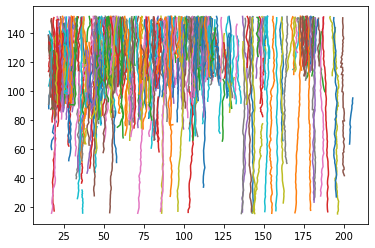

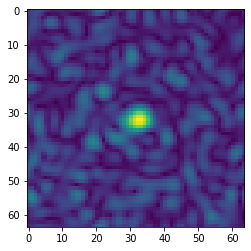

In [65]:
#@title
"""Saves images and positions for individual particles."""
particles_timeseries = []
particles_positions = []
num_particles = 516
IMAGE_SIZE = 64

for i in range(num_particles):
    frames = data[i]["Positions"][:,0].astype(int)
    positions = data[i]["Positions"][:,1:4]
    particles_positions.append(positions)

    roi_data = np.array(data[i]['ROI'][0])
    timeseries = []
    for j in range(roi_data.shape[0]):
        particleROI = np.fft.ifft2(exp_expand(roi_data[j,:], shape))
        particleROI = np.fft.fftshift(particleROI)
        particleROI = np.expand_dims(particleROI, axis = -1)
        timeseries.append(particleROI)
    particles_timeseries.append(np.array(timeseries))

for particle_id in range(num_particles):
    plt.plot(particles_positions[particle_id][:,0], particles_positions[particle_id][:,1])
plt.show()

for _ in range(1):
    plt.imshow(np.abs(particles_timeseries[0][_,:,:,0]))
    plt.show()

validation images shape (64, 64, 64, 1)


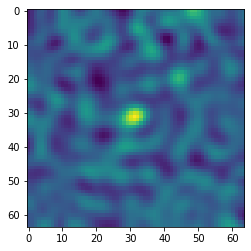

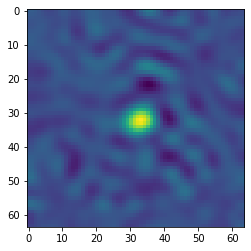

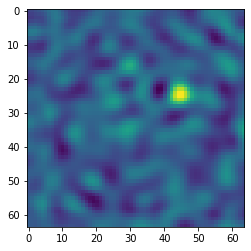

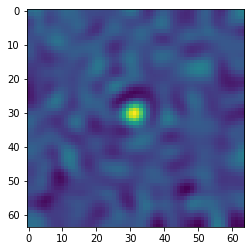

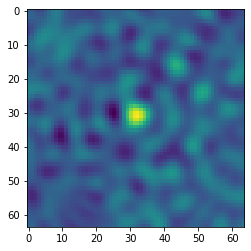

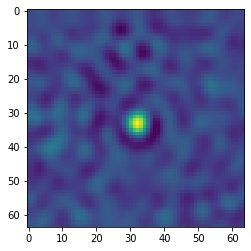

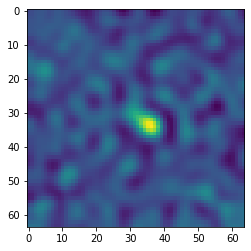

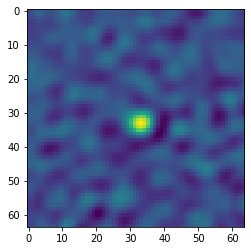

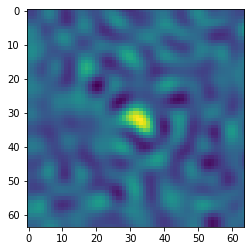

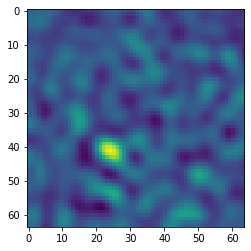

In [66]:
particle_id = 10
#training_images = np.stack((np.real(particles_timeseries[particle_id])[:,:,:,0], np.imag(particles_timeseries[particle_id][:,:,:,0])), axis=-1)
#print(f"training images shape {training_images.shape}")
validation_set = particles_timeseries[particle_id][:,:,:,:]
print(f"validation images shape {validation_set.shape}")

"""Create group/equivariance"""

crop_size = 64
padding = 32
wavelength = 525e-9
pixel_size = 114e-9 #??
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

args = dt.Arguments(
    translate=lambda: np.random.randn(2)*0.5,
    rotate=lambda: np.random.uniform(0, np.pi*2),
    z=lambda: np.random.randn(1)*20,
)

group = ( 
    dt.Affine(rotate=args.rotate) 
    >> dt.Affine(translate=args.translate) 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 0.00)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
)

equivariance = (
    dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >> dt.models.lodestar.TranslationalEquivariance(args.translate)
    >> dt.models.lodestar.Equivariance(1, args.z/10, indexes=2)
)

import random
def create_training_set(particles_timeseries):
    imgs = []
    for particle_id in range(0,len(particles_timeseries),1):
        img = np.stack((np.real(particles_timeseries[particle_id])[:,:,:,0], np.imag(particles_timeseries[particle_id][:,:,:,0])), axis=-1)
        img = img[10,:,:,:]
        imgs.append(img)
    return dt.Value(lambda: random.choice(np.array(imgs)))

training_set = create_training_set(particles_timeseries)
for _ in range(10):
    x = (training_set>>group).update()()
    plt.imshow(x[..., 1])
    plt.show()


In [67]:
#@title
"""Create custom layers"""
from tensorflow.math import abs, angle, real, imag, subtract, multiply

class CustomLayerOne(keras.layers.Layer):
    "Dpes nothing"
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), angle(image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerTwo(keras.layers.Layer):
    "Takes 2 layers as input and outputs 3 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), abs(norm_image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerThree(keras.layers.Layer):
    "Takes 2 layers as input and outputs 4 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)


In [68]:
#@title
"""Create models"""
num_outputs = 3

def create_model(custom_layer, nlayers):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,2)))
    model.add(custom_layer)
    model.add(keras.layers.Conv2D(32, 3, activation='relu', strides=(2,2)))
    for _ in range(nlayers):
        model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(num_outputs+1,1))
    model = dt.models.LodeSTAR(model=model, input_shape=(None, None, 2), num_outputs=num_outputs)
    model.specs = {"Layers": nlayers}
    model.totalhistory = {"total_loss":[], "consistency_loss":[]}
    model.compile(loss=["mae", "mae", "mae"], optimizer=tf.keras.optimizers.Adam(), loss_weights=[1, 1, 1])
    return model

models = [create_model(CustomLayerThree(), 1)]


In [69]:
"""Create generator"""
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    num_outputs=num_outputs, 
    transformation_function=(group, equivariance), 
    batch_size=8, 
    min_data_size=100, 
    max_data_size=201,
)

Generating 102 / 100 samples before starting training


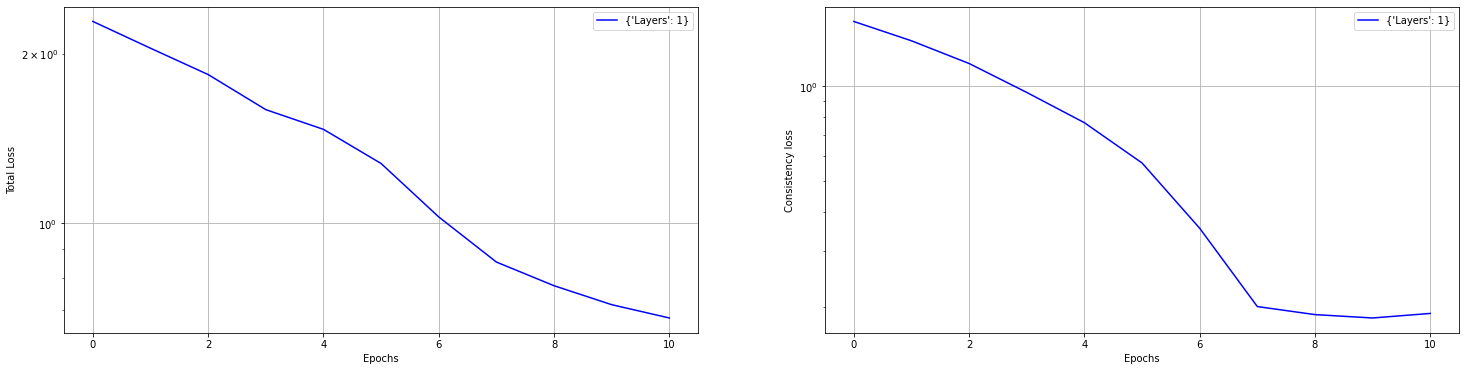

Generating 161 / 100 samples before starting training


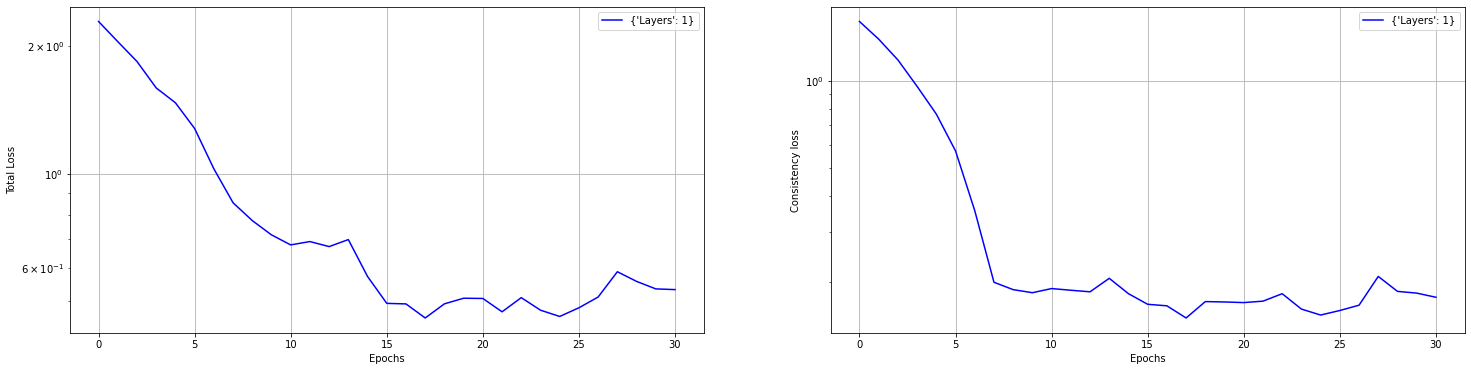

Generating 201 / 100 samples before starting training


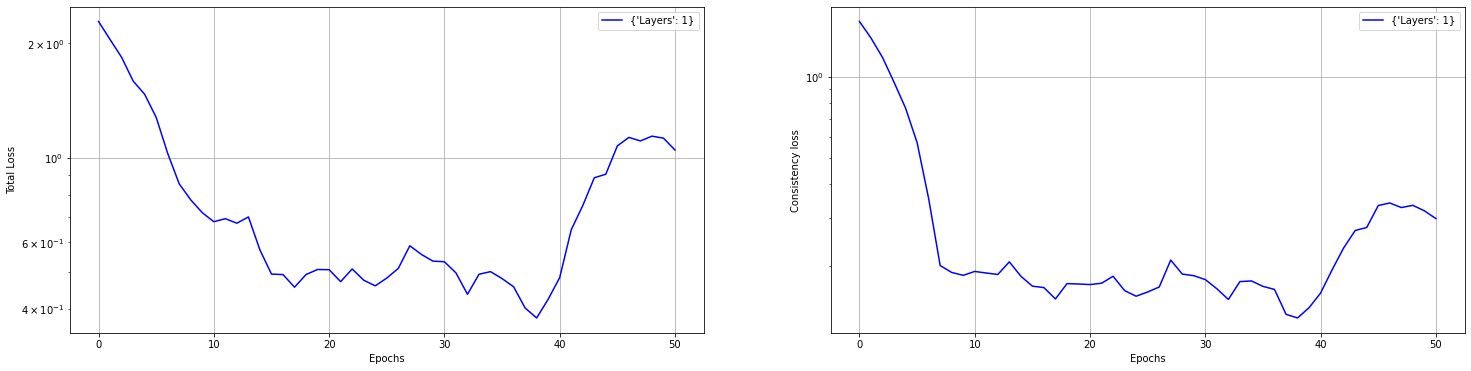

Generating 200 / 100 samples before starting training


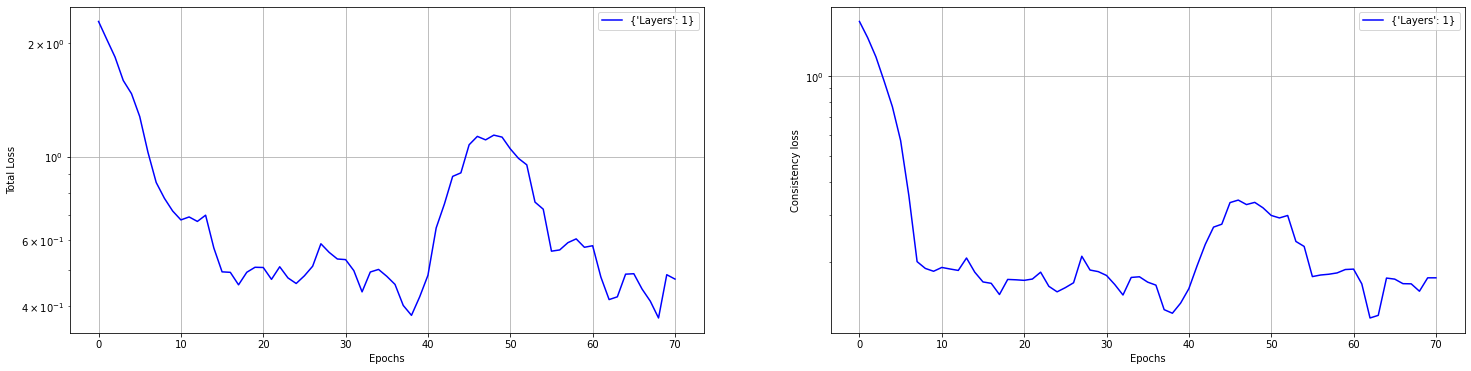

Generating 201 / 100 samples before starting training


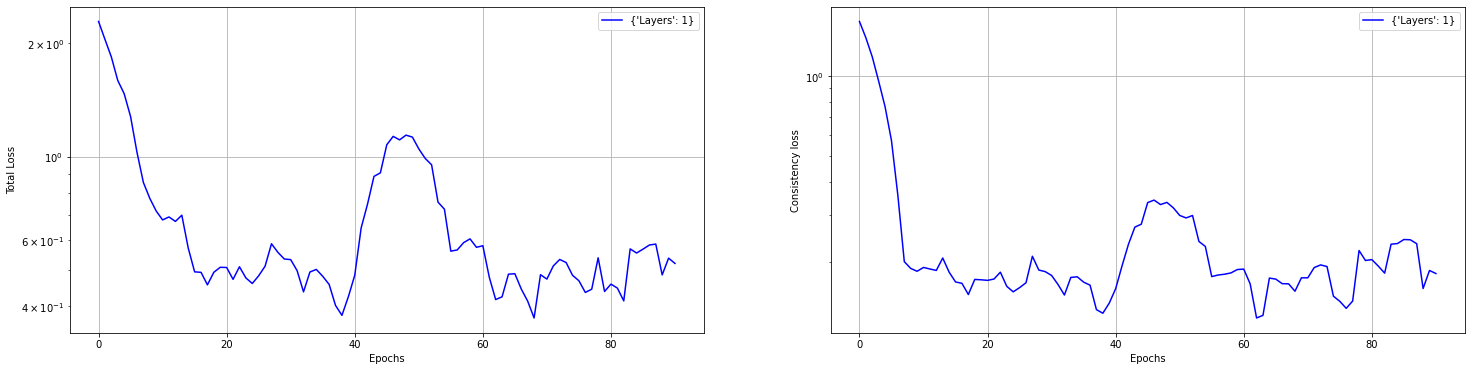

Generating 200 / 100 samples before starting training


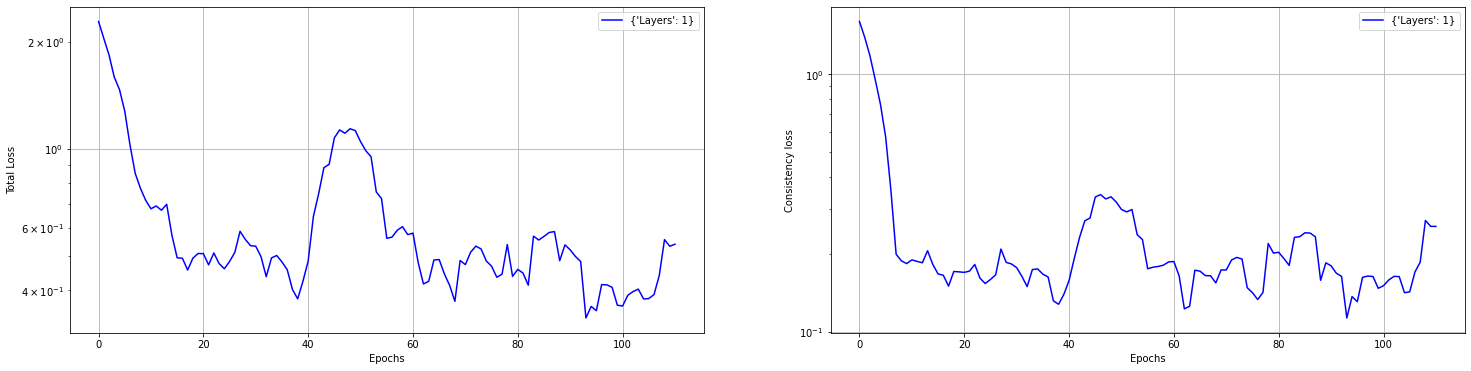

Generating 201 / 100 samples before starting training


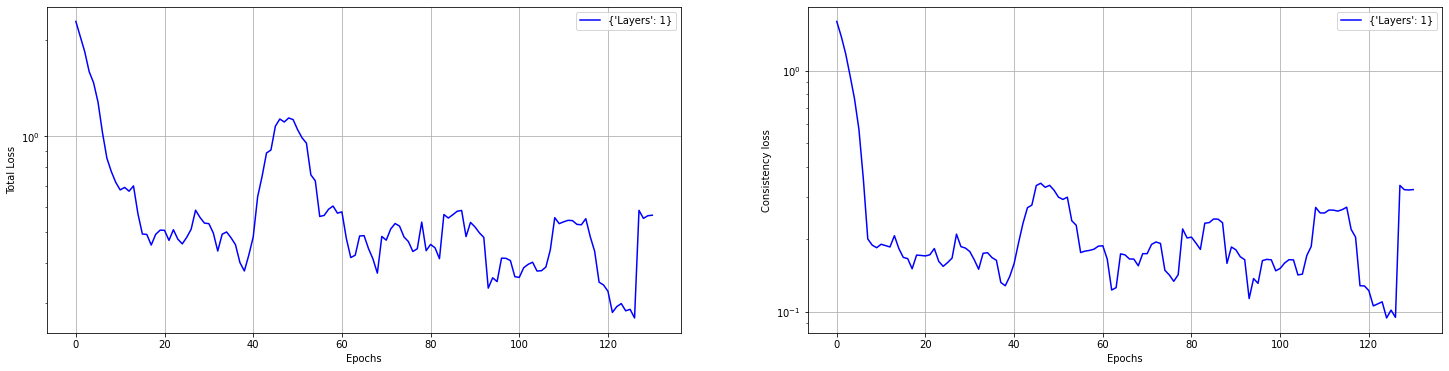

Generating 200 / 100 samples before starting training


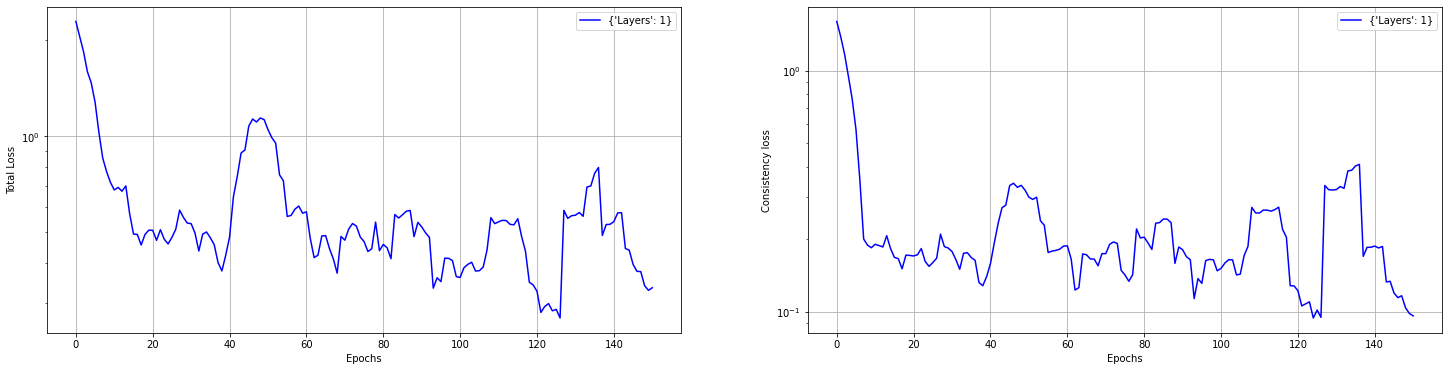

Generating 201 / 100 samples before starting training


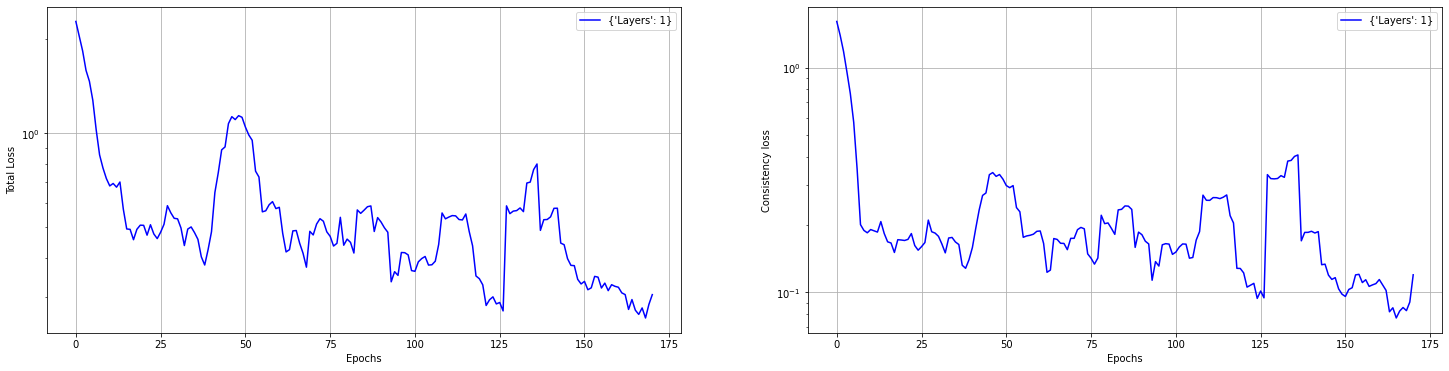

Generating 200 / 100 samples before starting training


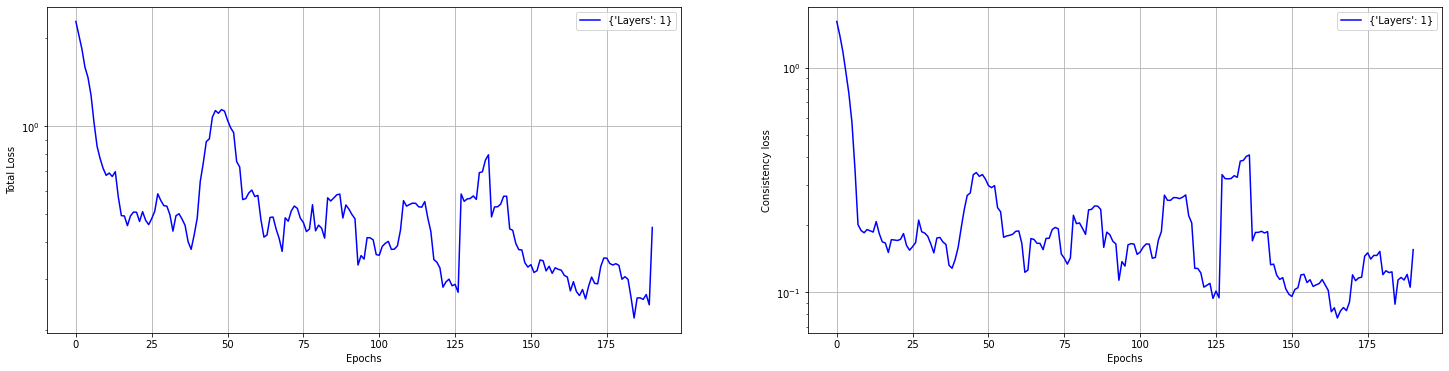

Generating 200 / 100 samples before starting training


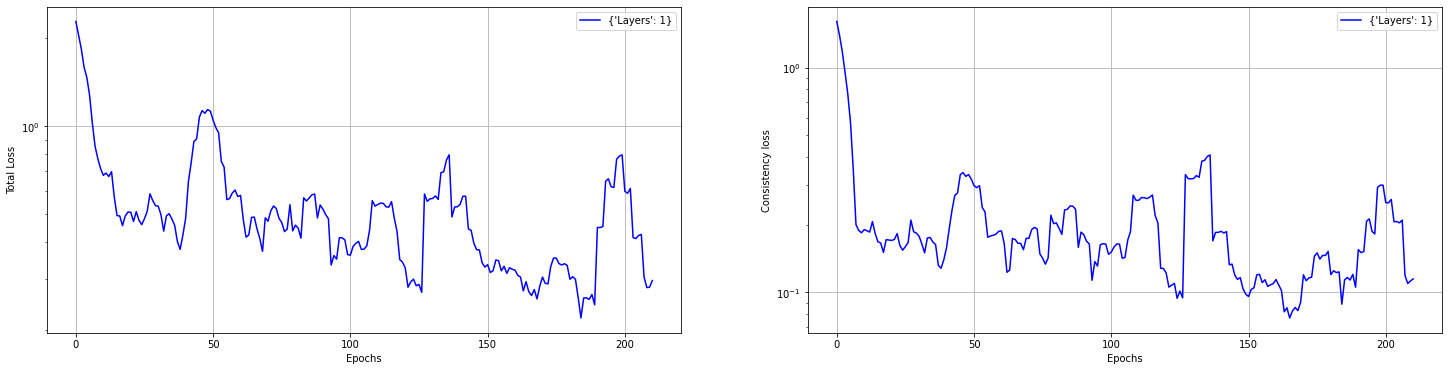

Generating 201 / 100 samples before starting training


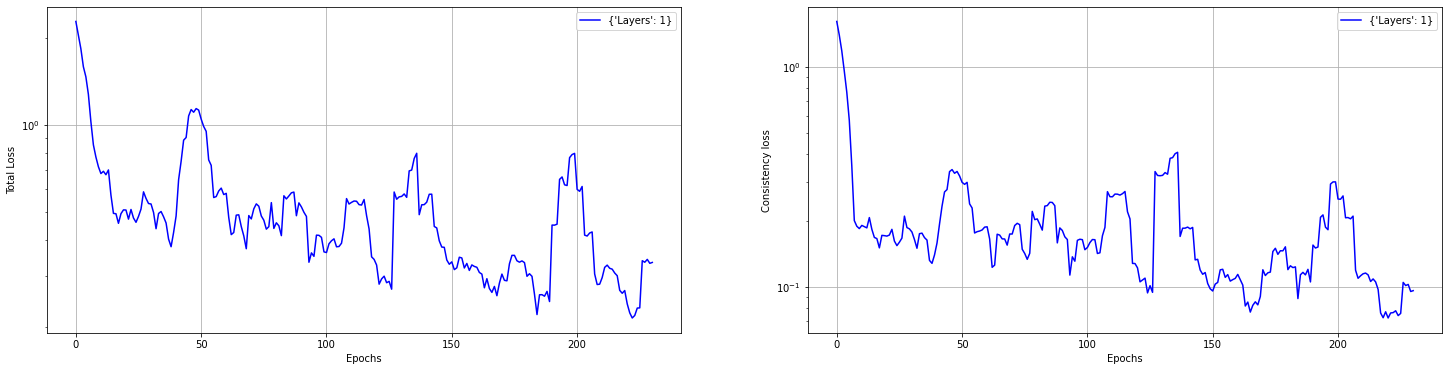

Generating 200 / 100 samples before starting training


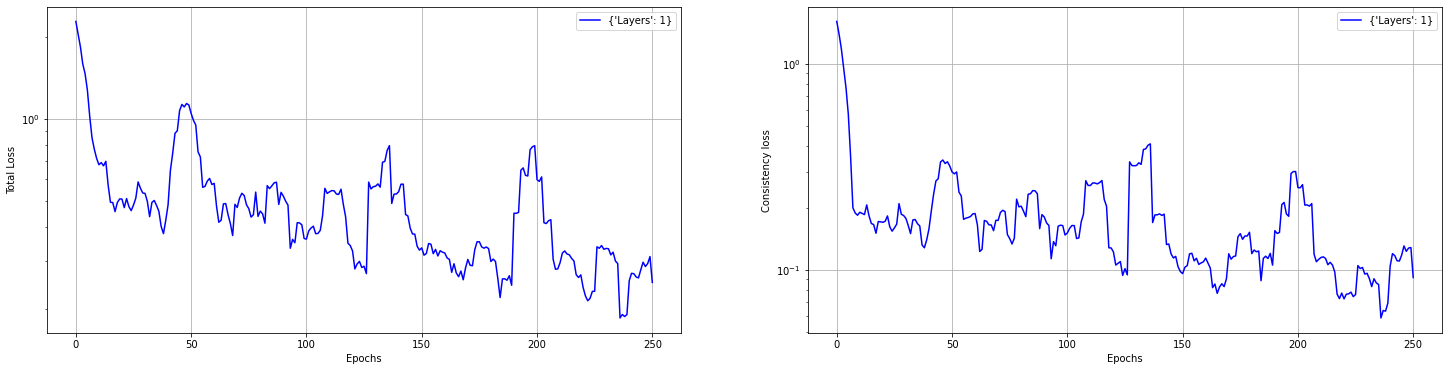

Generating 200 / 100 samples before starting training


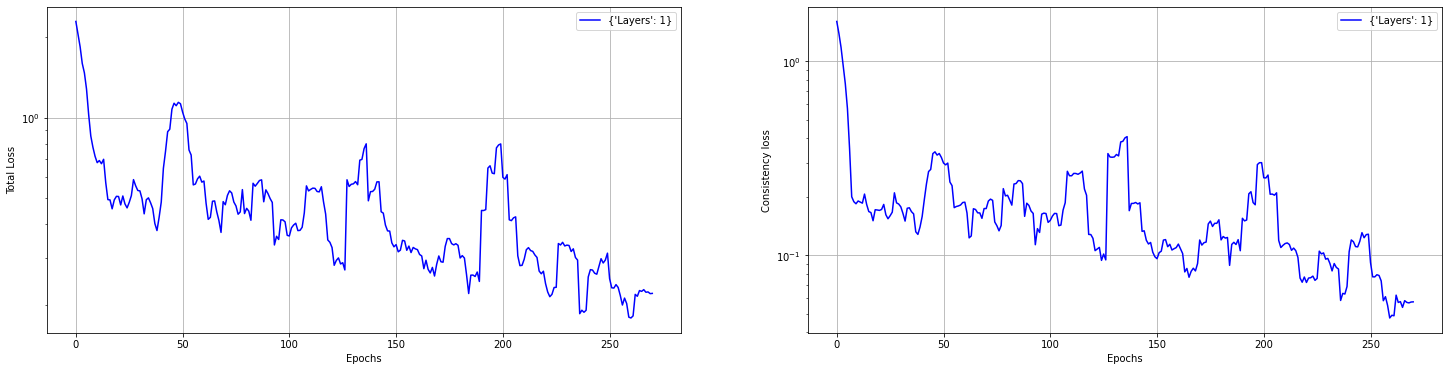

In [70]:
def save_progress(model, h):
    model.totalhistory["total_loss"].extend(h.history["total_loss"])
    model.totalhistory["consistency_loss"].extend(h.history["consistency_loss"])

def plot_progress(models):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    cc = (cycler(color=list('bgrcmyk')))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,6))
    ax1.set_prop_cycle(cc)
    ax2.set_prop_cycle(cc)

    for i, model in enumerate(models):
        ax1.plot(moving_average(model.totalhistory["total_loss"], 10), label=f"{model.specs}")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Total Loss")
        ax1.set_yscale("log")
        ax1.legend()

        ax2.plot(moving_average(model.totalhistory["consistency_loss"], 10), label=f"{model.specs}")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Consistency loss")
        ax2.set_yscale("log")
        ax2.legend()

    ax1.grid(True)
    ax2.grid(True)
    plt.show()

for _ in range(14):
    with generator:
        for model in models:
            h = model.fit(generator, epochs=20, steps_per_epoch=100, verbose=0)
            save_progress(model, h)
        plot_progress(models)
        



In [71]:
for model in models:
    print(model.specs)
    model.summary()


{'Layers': 1}
Model: "lode_star_base_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 29, 29, 4)         19940     
                                                                 
Total params: 19,940
Trainable params: 19,940
Non-trainable params: 0
_________________________________________________________________


In [72]:
def get_propagation_matrix(shape, to_z, pixel_size, wavelength):

    k = 2 * np.pi / wavelength
    yr, xr, *_ = shape

    x = 2 * np.pi / pixel_size * np.arange(-(xr / 2 - 1 / 2), (xr / 2 + 1 / 2), 1) / xr
    y = 2 * np.pi / pixel_size * np.arange(-(yr / 2 - 1 / 2), (yr / 2 + 1 / 2), 1) / yr
    KXk, KYk = np.meshgrid(x, y)

    K = np.real(
        np.sqrt(np.array(1 - (KXk / k) ** 2 - (KYk / k) ** 2, dtype=np.complex64))
    )
    C = np.fft.fftshift(((KXk / k) ** 2 + (KYk / k) ** 2 < 1) * 1.0)

    return C * np.fft.fftshift(np.exp(k * 1j * to_z * (K - 1)))

def fourier_transform(image, padding=32):
    im = np.pad(image, ((padding, padding), (padding, padding)), mode="symmetric")
    return np.fft.fft2(im)

def inverse_fourier_transform(image, padding=32):
    im = np.fft.ifft2(image)
    return im[padding:-padding, padding:-padding]

def fourier_transform_transformation(image, Tz, Tzinv, i):
    if i < 0:
        image *= Tzinv ** np.abs(i)
    else:
        image *= Tz ** i
    return image

def propagate(image, z):
    """Re-propagate the images using PAS"""
    ft_image = fourier_transform(image[:,:,0])
    prop_ft_image = fourier_transform_transformation(ft_image, crop_propagation_backward, crop_propagation_forward, z)
    return np.expand_dims(inverse_fourier_transform(prop_ft_image),axis=-1)

{'Layers': 1}
PROPAGERADE BILDER


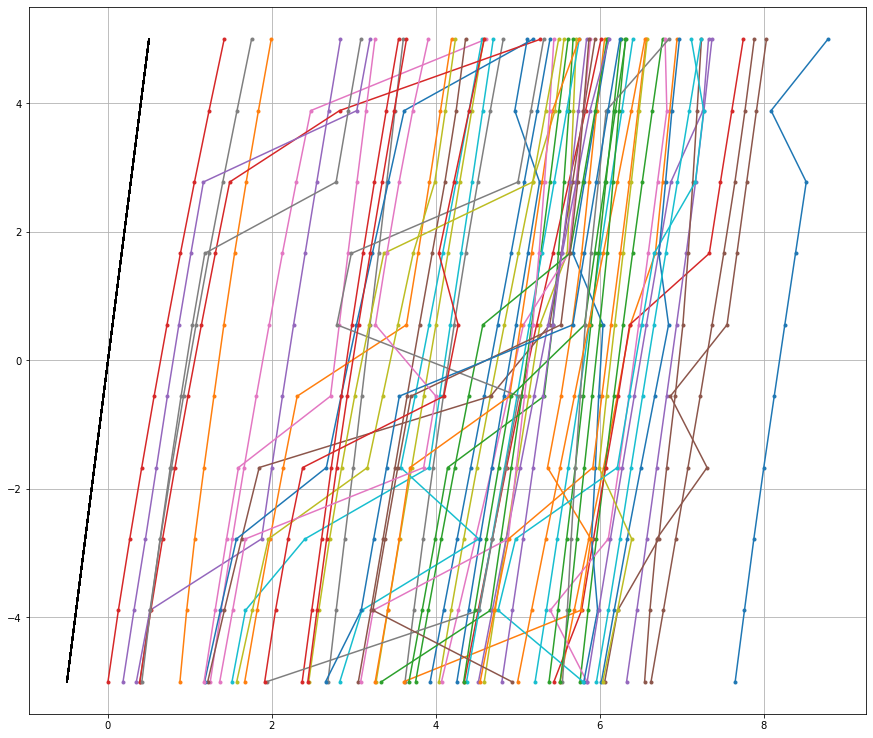

STD: 3.163


In [73]:
cc = (cycler(color=list('bgrcmyk')))

def predict_on_stack(model, val_stack):
    """returns a numpy tensor containing propagated distance as well as the prediction, for ever propagation distance and every image images"""
    try:
        dets = np.array(model.predict_and_detect(val_stack, mode="ratio"))
    except ValueError as E:
        dets = np.expand_dims(np.zeros((val_stack.shape[0],3)), axis=0)
        print(E)
    dets = reshape_dets(dets)
    dets *= multfact
    #dets[:,2] = dets[:,2] - np.mean(dets[:,2])
    return dets

def reshape_dets(dets):
    """Removes all particles but the one closest to the center. If no particles are detected, sets the value to 0."""
    out = []
    for coords in dets:
        if coords.shape != (0, 3):
            x, y = IMAGE_SIZE//2, IMAGE_SIZE//2
            idx = np.argmin(np.array(coords[:,:2]- np.array((x, y))), axis=0)[0]
            out.append(coords[idx,:])
        else:
            out.append([0,0,0])
    return np.array(out)

def create_validation_stack(images, z_list):
    """"""
    output = []
    for i in range(images.shape[0]):
        image = images[i,:,:,:]
        stack = []
        for z in z_list:
            stack.append(propagate(image, z))
        output.append(stack)
    return np.stack((np.real(output), np.imag(output)), axis=-1)[:,:,:,:,0,:]

def plot_preds(val_stack):
    for particle_id in range(from_id, from_id+num_samples):
        dets = model.predict_and_detect(val_stack[:,:,:,:], mode="ratio"), 
        plt.figure(figsize=(10, 10))
        plt.imshow(np.abs(val_stack[stack_id,:,:,0]+1j*val_stack[stack_id,:,:,1]), cmap="bone")
        dets = np.squeeze(np.array(dets))
        print(dets)
        plt.scatter(dets[stack_id,1], dets[stack_id,0], s=200, facecolor="none", linewidths=3, edgecolors="g")
        plt.show()
        
        dets[:,2] *= multfact
        #dets[:,2] -= np.mean(dets[:,2])
        #[print(d) for d in dets]

def evaluate_model(model, val_stack, prop_range):
    accs = []
    for i in range(num_samples):
        accs.append(predict_on_stack(model, val_stack[from_id+i])[:,2])
    accs = np.array(accs)
    accs = accs - np.min(accs)

    stds = []
    fig, ax = plt.subplots(1,1, figsize=(15,13))
    for i in range(accs.shape[0]):
        ax.plot(prop_range/10, prop_range, 'k')
        ax.plot(accs[i,:].flatten(), prop_range, '.-')
        ax.grid(True)
        stds.append(np.std(accs[i,:].flatten() - prop_range))
    plt.show()
    print(f"STD: {np.std((accs-prop_range).flatten()):.3f}", )

model = models[-1]
#for model in models:
prop_range = np.linspace(-5, 5, 10) #np.random.randn(70)
from_id = 0
num_samples = len(particles_positions[particle_id][:,0])
stack_id = len(prop_range)//2
multfact = -1
print(model.specs)
print("PROPAGERADE BILDER")
val_stack = create_validation_stack(validation_set, prop_range)
evaluate_model(model, val_stack, prop_range)

val_stack = np.stack( (np.real(validation_set[:,:,:,0]), np.imag(validation_set[:,:,:,0])), axis=-1)
corrections = predict_on_stack(model, val_stack)
x_lode, y_lode, z_lode = corrections[:,0], corrections[:,1], corrections[:,2]
x_matlab, y_matlab, z_matlab = particles_positions[particle_id][:,0], particles_positions[particle_id][:,1], particles_positions[particle_id][:,2]
z_lode = z_lode/-10
z_lode = z_lode - np.mean(z_lode)
x_new, y_new, z_new = x_matlab+(32+x_lode)*0.114, y_matlab+(32+y_lode)*0.114, z_lode+z_matlab


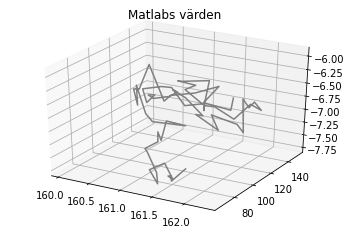

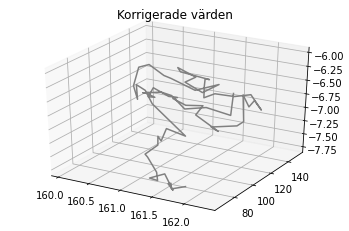

Matlab!


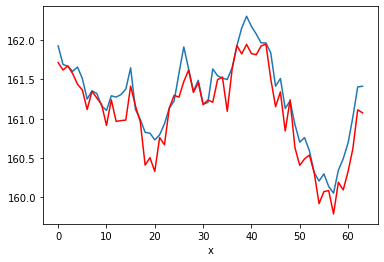

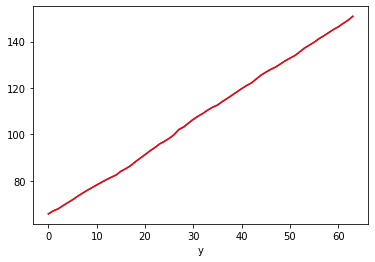

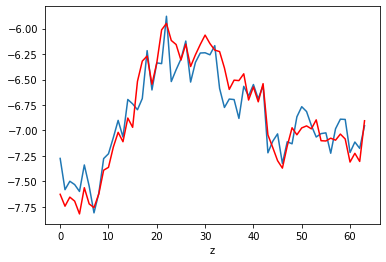

In [74]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.plot3D(x_matlab, y_matlab, z_matlab, 'gray')
ax.set_title("Matlabs värden")
plt.show()

ax = plt.axes(projection='3d')
ax.plot3D(x_matlab, y_matlab, z_matlab+z_lode, 'gray')
ax.set_title("Korrigerade värden")
plt.show()

print("Matlab!")
plt.plot(list(range(len(x_matlab))), x_matlab)
plt.xlabel("x")
plt.plot(list(range(len(x_lode))), x_new, 'r')
plt.show()

plt.plot(list(range(len(y_matlab))), y_matlab)
plt.plot(list(range(len(y_lode))), y_new, 'r')
plt.xlabel("y")
plt.show()

plt.plot(list(range(len(z_matlab))), z_matlab)
plt.plot(list(range(len(z_lode))), z_new, 'r')
plt.xlabel("z")
plt.show()

#https://journals.aps.org/pre/pdf/10.1103/PhysRevE.89.022726

In [75]:
def calc_sigma(arr):
    sigma2 = np.abs(np.mean(
        np.multiply(
            np.diff(arr[:-1]), 
            np.diff(arr[1:])
            )
    ))
    return np.sqrt(sigma2)

print(f"sigma_x_new: {calc_sigma(x_new):.3f}")
print(f"sigma_x_matlab: {calc_sigma(x_matlab):.3f}")
print(f"sigma_z_new: {calc_sigma(z_new):.3f}")
print(f"sigma_z_matlab: {calc_sigma(z_matlab):.3f}")


sigma_x_new: 0.116
sigma_x_matlab: 0.085
sigma_z_new: 0.056
sigma_z_matlab: 0.138


PARTICLE ID: 0  PARTICLE ID: 1  z_mult: 1.192, improvement: 0.23
PARTICLE ID: 2  z_mult: 1.643, improvement: 0.45
PARTICLE ID: 3  z_mult: 1.998, improvement: 0.53
PARTICLE ID: 4  z_mult: 1.710, improvement: 0.43
PARTICLE ID: 5  z_mult: 1.823, improvement: 0.49
PARTICLE ID: 6  z_mult: 1.499, improvement: 0.50
PARTICLE ID: 7  z_mult: 2.349, improvement: 0.58
PARTICLE ID: 8  z_mult: 1.546, improvement: 0.46
PARTICLE ID: 9  z_mult: 1.343, improvement: 0.28
PARTICLE ID: 10  z_mult: 1.220, improvement: 0.41


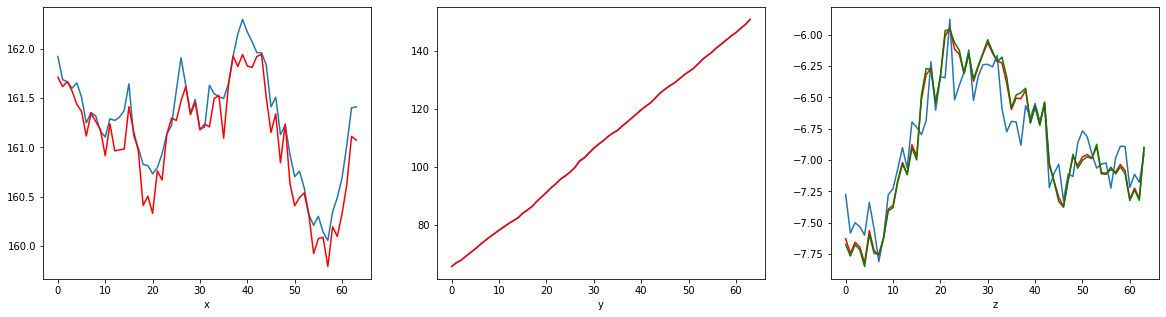

PARTICLE ID: 11  z_mult: 2.080, improvement: 0.35
PARTICLE ID: 12  z_mult: 2.084, improvement: 0.55
PARTICLE ID: 13  z_mult: 1.915, improvement: 0.49
PARTICLE ID: 14  z_mult: 1.558, improvement: 0.47
PARTICLE ID: 15  z_mult: -2.795, improvement: 1.08


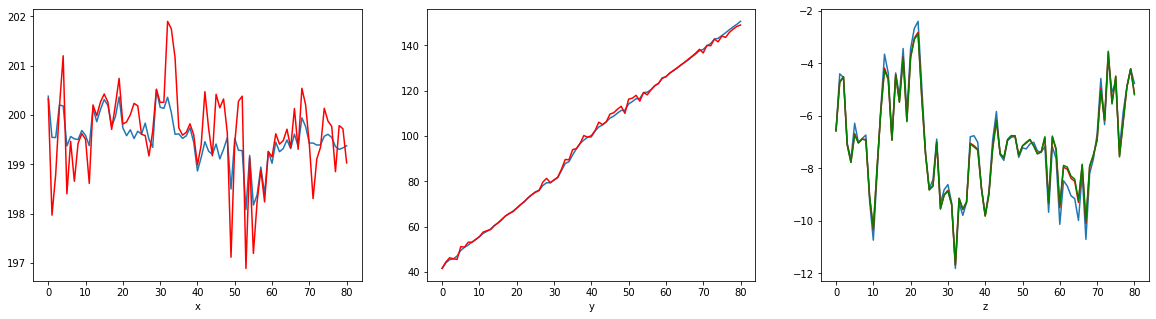

PARTICLE ID: 16  z_mult: -1.355, improvement: 1.34
PARTICLE ID: 17  z_mult: 0.966, improvement: 0.15


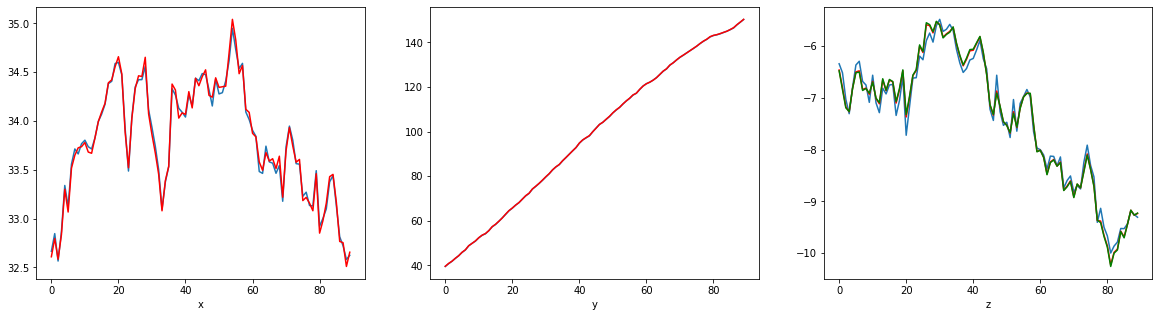

PARTICLE ID: 18  z_mult: 0.481, improvement: 0.63
PARTICLE ID: 19  z_mult: 2.548, improvement: 0.99
PARTICLE ID: 20  z_mult: 1.615, improvement: 0.40
PARTICLE ID: 21  z_mult: 1.696, improvement: 0.45
PARTICLE ID: 22  z_mult: 2.436, improvement: 0.70
PARTICLE ID: 23  z_mult: 1.930, improvement: 0.74


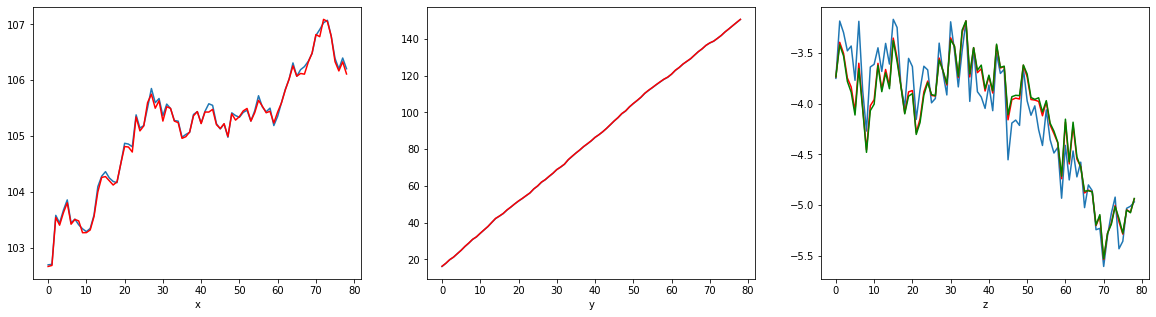

PARTICLE ID: 24  z_mult: 1.751, improvement: 0.50
PARTICLE ID: 25  z_mult: 1.777, improvement: 0.49
PARTICLE ID: 26  z_mult: 2.086, improvement: 0.53
PARTICLE ID: 27  z_mult: 1.613, improvement: 0.46
PARTICLE ID: 28  z_mult: 0.996, improvement: 0.45
PARTICLE ID: 29  z_mult: 1.909, improvement: 0.48
PARTICLE ID: 30  z_mult: 2.699, improvement: 0.75
PARTICLE ID: 31  z_mult: 3.044, improvement: 0.61
PARTICLE ID: 32  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


z_mult: 1.651, improvement: 0.47
PARTICLE ID: 33  z_mult: 0.512, improvement: 0.98


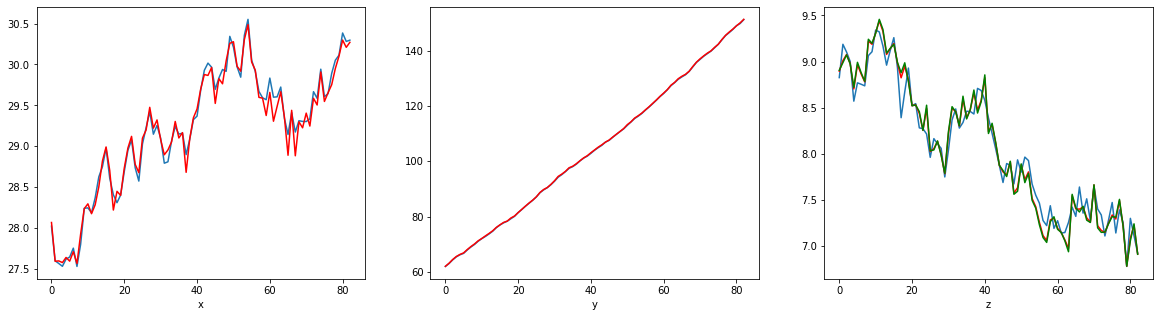

PARTICLE ID: 34  z_mult: 1.277, improvement: 0.33
PARTICLE ID: 35  z_mult: 0.118, improvement: 3.02
PARTICLE ID: 36  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


z_mult: 1.205, improvement: 0.27
PARTICLE ID: 37  z_mult: 3.237, improvement: 1.04
PARTICLE ID: 38  z_mult: 1.018, improvement: 0.35
PARTICLE ID: 39  z_mult: 1.398, improvement: 0.41
PARTICLE ID: 40  z_mult: 1.318, improvement: 0.66
PARTICLE ID: 41  z_mult: 1.449, improvement: 0.42
PARTICLE ID: 42  z_mult: 2.075, improvement: 0.38
PARTICLE ID: 43  z_mult: 1.624, improvement: 0.32
PARTICLE ID: 44  z_mult: 1.934, improvement: 0.65
PARTICLE ID: 45  z_mult: 1.768, improvement: 0.62
PARTICLE ID: 46  z_mult: 2.182, improvement: 0.58
PARTICLE ID: 47  z_mult: 1.326, improvement: 0.42
PARTICLE ID: 48  z_mult: 1.812, improvement: 0.55


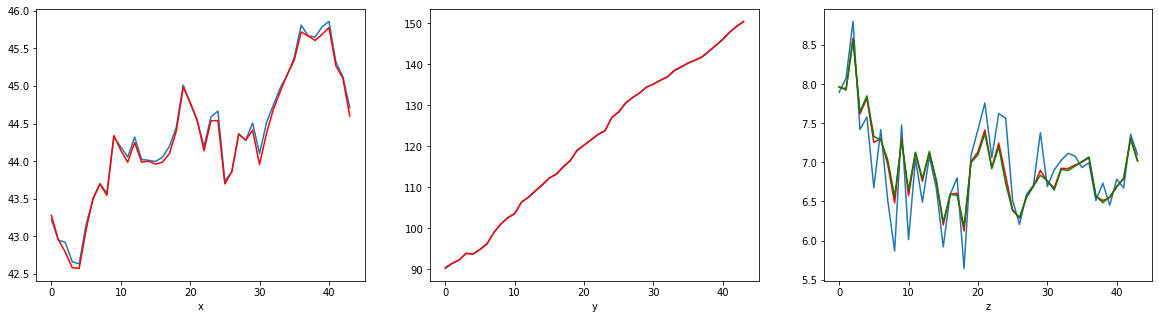

PARTICLE ID: 49  z_mult: 1.634, improvement: 0.46
PARTICLE ID: 50  PARTICLE ID: 51  z_mult: 1.690, improvement: 0.44
PARTICLE ID: 52  z_mult: 0.828, improvement: 0.98
PARTICLE ID: 53  z_mult: 2.491, improvement: 0.63
PARTICLE ID: 54  z_mult: 1.771, improvement: 0.50


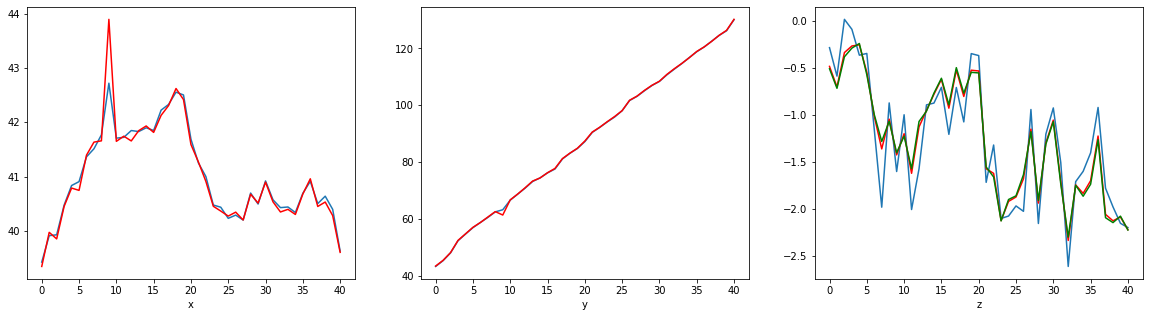

PARTICLE ID: 55  z_mult: 1.864, improvement: 0.47
PARTICLE ID: 56  z_mult: 0.788, improvement: 0.32
PARTICLE ID: 57  z_mult: 1.739, improvement: 0.48
PARTICLE ID: 58  z_mult: 2.639, improvement: 0.70
PARTICLE ID: 59  z_mult: 1.753, improvement: 0.44
PARTICLE ID: 60  z_mult: 2.108, improvement: 0.54


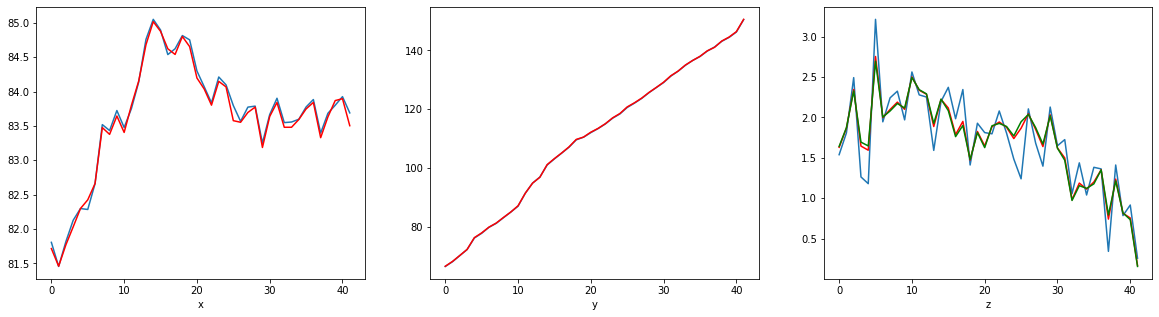

PARTICLE ID: 61  z_mult: 1.397, improvement: 0.48
PARTICLE ID: 62  z_mult: 2.019, improvement: 0.57
PARTICLE ID: 63  z_mult: 1.705, improvement: 0.77


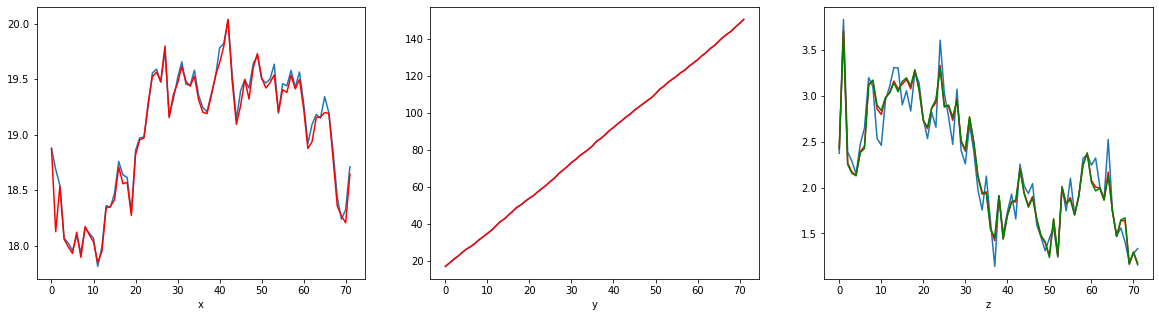

PARTICLE ID: 64  z_mult: 1.983, improvement: 0.50
PARTICLE ID: 65  z_mult: 1.081, improvement: 0.17
PARTICLE ID: 66  z_mult: 1.179, improvement: 0.32
PARTICLE ID: 67  z_mult: 1.306, improvement: 0.32
PARTICLE ID: 68  z_mult: 1.144, improvement: 0.74


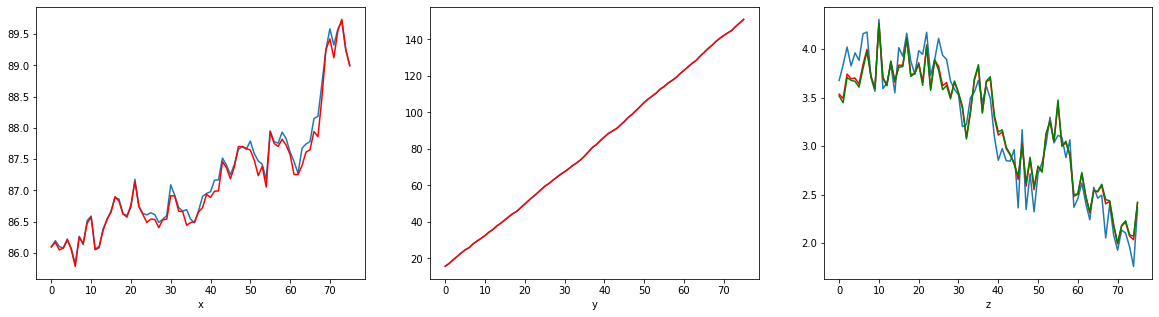

PARTICLE ID: 69  z_mult: 2.854, improvement: 0.66
PARTICLE ID: 70  z_mult: 2.727, improvement: 0.58
PARTICLE ID: 71  z_mult: 1.850, improvement: 0.53
PARTICLE ID: 72  z_mult: 1.449, improvement: 0.66
PARTICLE ID: 73  z_mult: 1.815, improvement: 0.46
PARTICLE ID: 74  z_mult: 1.655, improvement: 0.46
PARTICLE ID: 75  z_mult: 2.388, improvement: 0.67
PARTICLE ID: 76  z_mult: 1.805, improvement: 0.51
PARTICLE ID: 77  z_mult: 1.646, improvement: 0.48
PARTICLE ID: 78  z_mult: 1.965, improvement: 0.67


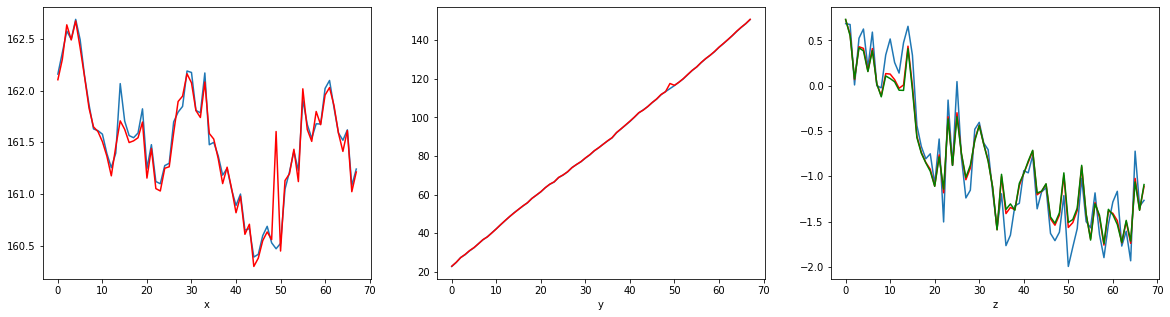

PARTICLE ID: 79  z_mult: 1.900, improvement: 0.62
PARTICLE ID: 80  z_mult: -0.533, improvement: 1.15
PARTICLE ID: 81  z_mult: 2.906, improvement: 0.74
PARTICLE ID: 82  z_mult: 0.334, improvement: 1.07
PARTICLE ID: 83  z_mult: 1.453, improvement: 0.37
PARTICLE ID: 84  z_mult: 2.670, improvement: 0.72
PARTICLE ID: 85  z_mult: 1.642, improvement: 0.58
PARTICLE ID: 86  z_mult: 2.253, improvement: 0.67
PARTICLE ID: 87  z_mult: 1.527, improvement: 0.44
PARTICLE ID: 88  z_mult: 1.025, improvement: 0.12
PARTICLE ID: 89  z_mult: 1.705, improvement: 0.56
PARTICLE ID: 90  z_mult: 1.449, improvement: 0.34
PARTICLE ID: 91  z_mult: -0.351, improvement: 1.34
PARTICLE ID: 92  z_mult: 1.712, improvement: 0.47
PARTICLE ID: 93  z_mult: 1.241, improvement: 0.27
PARTICLE ID: 94  z_mult: 1.655, improvement: 0.50
PARTICLE ID: 95  z_mult: 1.661, improvement: 0.50
PARTICLE ID: 96  z_mult: 1.657, improvement: 0.54
PARTICLE ID: 97  z_mult: 1.315, improvement: 0.79
PARTICLE ID: 98  z_mult: 1.155, improvement: 0.4

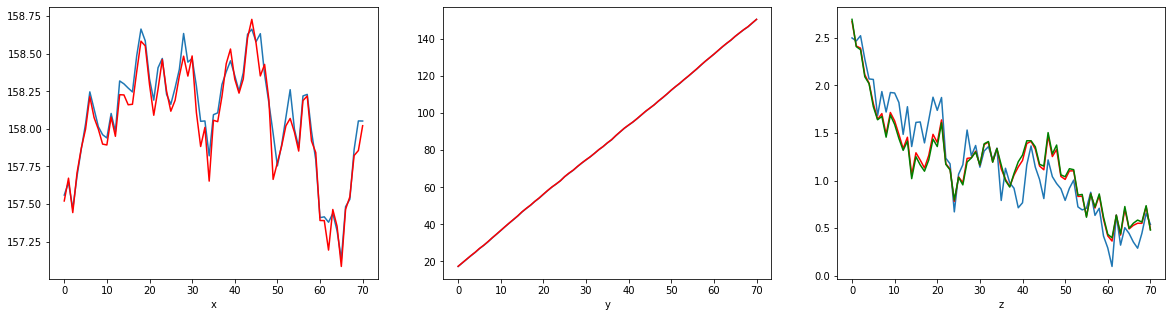

PARTICLE ID: 120  z_mult: 1.765, improvement: 0.44
PARTICLE ID: 121  z_mult: 1.373, improvement: 0.44
PARTICLE ID: 122  z_mult: 1.146, improvement: 0.28
PARTICLE ID: 123  z_mult: 1.781, improvement: 0.46
PARTICLE ID: 124  z_mult: 3.665, improvement: 0.78
PARTICLE ID: 125  z_mult: -1.609, improvement: 1.60
PARTICLE ID: 126  z_mult: 2.015, improvement: 0.36
PARTICLE ID: 127  z_mult: 1.089, improvement: 0.18
PARTICLE ID: 128  z_mult: 2.002, improvement: 0.40
PARTICLE ID: 129  z_mult: 1.910, improvement: 0.49
PARTICLE ID: 130  z_mult: 2.250, improvement: 0.95
PARTICLE ID: 131  z_mult: 1.726, improvement: 0.54
PARTICLE ID: 132  z_mult: 2.061, improvement: 0.39
PARTICLE ID: 133  z_mult: 1.629, improvement: 0.51
PARTICLE ID: 134  z_mult: 1.747, improvement: 0.48


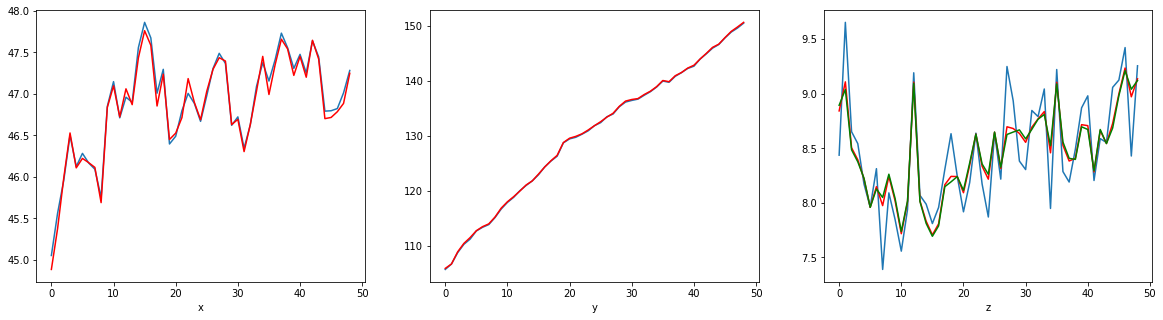

PARTICLE ID: 135  z_mult: 1.790, improvement: 0.51
PARTICLE ID: 136  z_mult: 1.517, improvement: 0.60
PARTICLE ID: 137  z_mult: 1.643, improvement: 0.89
PARTICLE ID: 138  z_mult: 2.107, improvement: 0.57


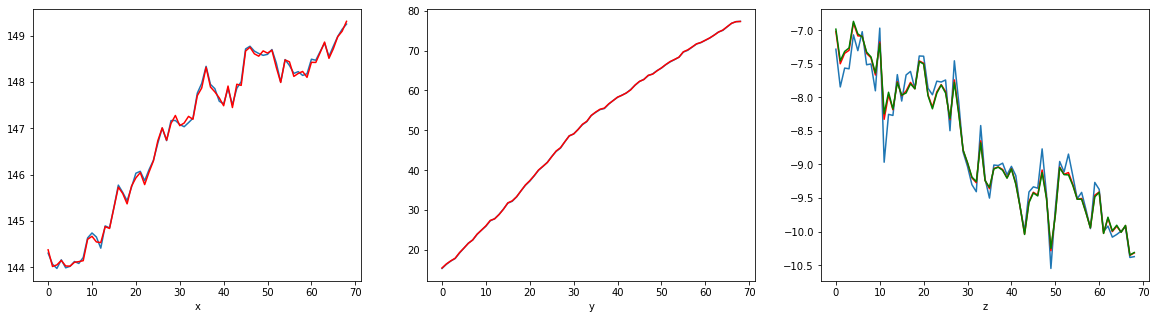

PARTICLE ID: 139  z_mult: 2.208, improvement: 0.66
PARTICLE ID: 140  z_mult: 1.560, improvement: 0.43
PARTICLE ID: 141  z_mult: 1.511, improvement: 0.39
PARTICLE ID: 142  z_mult: 1.800, improvement: 0.61
PARTICLE ID: 143  z_mult: 1.708, improvement: 0.45
PARTICLE ID: 144  z_mult: 1.197, improvement: 0.26
PARTICLE ID: 145  z_mult: 1.960, improvement: 0.31
PARTICLE ID: 146  z_mult: 3.064, improvement: 0.84
PARTICLE ID: 147  z_mult: 0.754, improvement: 0.96


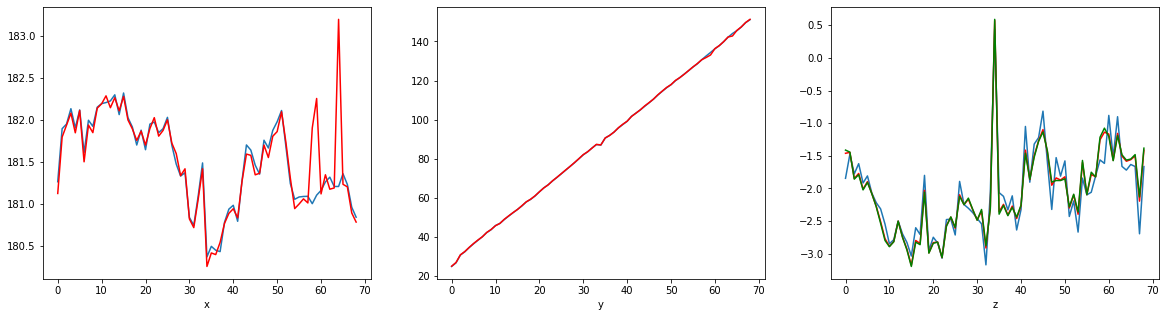

PARTICLE ID: 148  z_mult: 1.531, improvement: 0.71
PARTICLE ID: 149  z_mult: 1.582, improvement: 0.44
PARTICLE ID: 150  PARTICLE ID: 151  z_mult: 1.656, improvement: 0.46
PARTICLE ID: 152  z_mult: 2.519, improvement: 0.58
PARTICLE ID: 153  z_mult: 1.492, improvement: 0.42
PARTICLE ID: 154  z_mult: 1.729, improvement: 0.57
PARTICLE ID: 155  z_mult: 2.542, improvement: 0.50
PARTICLE ID: 156  z_mult: 2.035, improvement: 0.54
PARTICLE ID: 157  z_mult: 1.988, improvement: 0.56
PARTICLE ID: 158  z_mult: 1.122, improvement: 0.29
PARTICLE ID: 159  z_mult: 1.720, improvement: 0.45
PARTICLE ID: 160  z_mult: 1.643, improvement: 0.81
PARTICLE ID: 161  z_mult: 1.367, improvement: 0.35
PARTICLE ID: 162  z_mult: 2.234, improvement: 0.56
PARTICLE ID: 163  z_mult: -1.403, improvement: 1.92
PARTICLE ID: 164  z_mult: 2.162, improvement: 0.57
PARTICLE ID: 165  z_mult: 2.102, improvement: 0.60
PARTICLE ID: 166  z_mult: 1.764, improvement: 0.51
PARTICLE ID: 167  z_mult: 1.855, improvement: 0.55
PARTICLE ID:

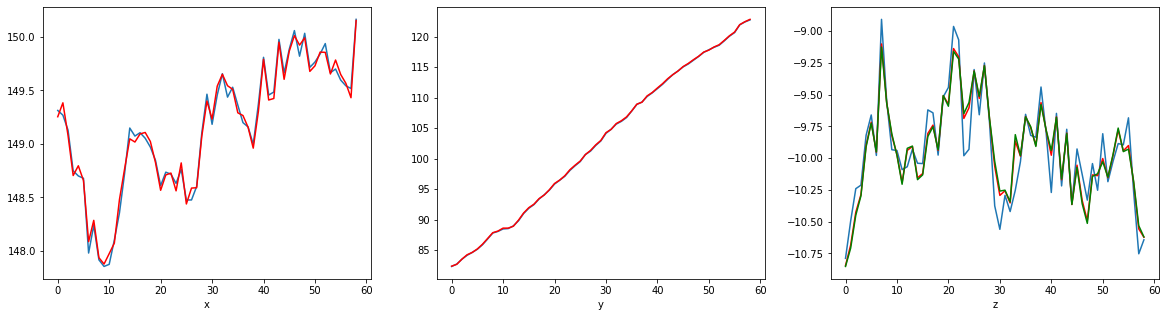

PARTICLE ID: 174  z_mult: 1.832, improvement: 0.51
PARTICLE ID: 175  z_mult: 1.970, improvement: 0.62
PARTICLE ID: 176  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


z_mult: 1.547, improvement: 0.50


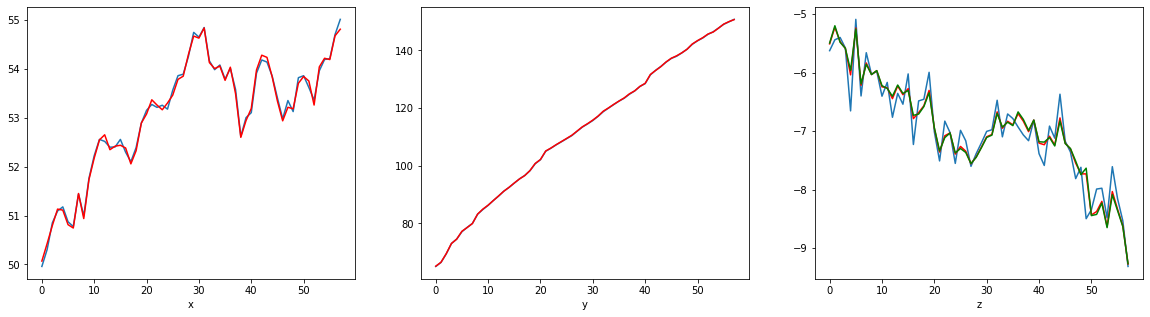

PARTICLE ID: 177  z_mult: 1.649, improvement: 0.46
PARTICLE ID: 178  z_mult: 3.830, improvement: 0.83
PARTICLE ID: 179  z_mult: 1.279, improvement: 0.29
PARTICLE ID: 180  z_mult: 1.687, improvement: 0.50
PARTICLE ID: 181  z_mult: 2.061, improvement: 0.43
PARTICLE ID: 182  z_mult: 2.038, improvement: 0.35
PARTICLE ID: 183  z_mult: 1.726, improvement: 0.55
PARTICLE ID: 184  z_mult: 2.021, improvement: 0.54
PARTICLE ID: 185  z_mult: 2.389, improvement: 0.65
PARTICLE ID: 186  z_mult: 1.160, improvement: 0.40
PARTICLE ID: 187  z_mult: 1.760, improvement: 0.59
PARTICLE ID: 188  z_mult: 1.559, improvement: 0.38
PARTICLE ID: 189  z_mult: 1.227, improvement: 0.61
PARTICLE ID: 190  z_mult: 1.230, improvement: 0.60
PARTICLE ID: 191  z_mult: 1.710, improvement: 0.60
PARTICLE ID: 192  z_mult: 1.243, improvement: 0.21
PARTICLE ID: 193  z_mult: 2.304, improvement: 0.88
PARTICLE ID: 194  z_mult: 1.566, improvement: 0.46
PARTICLE ID: 195  z_mult: 1.419, improvement: 0.59


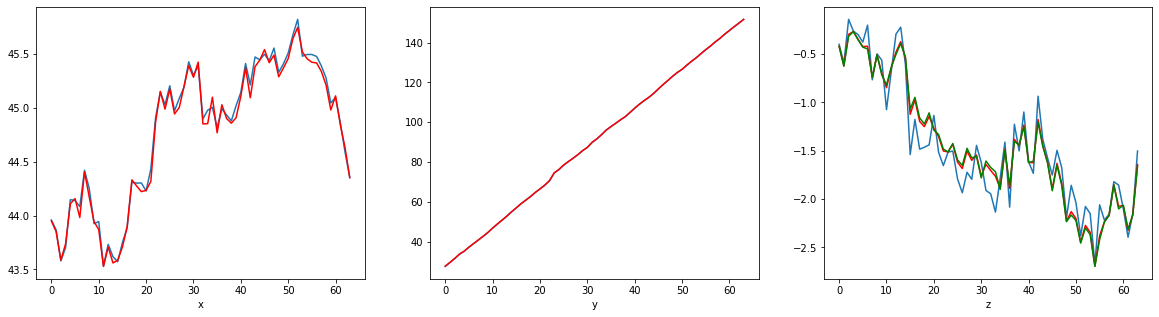

PARTICLE ID: 196  z_mult: 0.740, improvement: 0.65


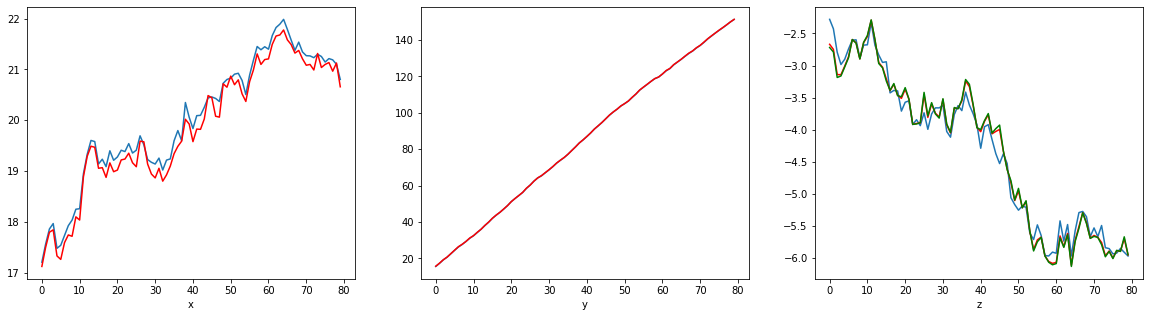

PARTICLE ID: 197  z_mult: 2.128, improvement: 0.75
PARTICLE ID: 198  z_mult: 1.708, improvement: 0.47
PARTICLE ID: 199  z_mult: 1.512, improvement: 0.49
PARTICLE ID: 200  PARTICLE ID: 201  z_mult: 1.823, improvement: 0.59
PARTICLE ID: 202  z_mult: 1.700, improvement: 0.53
PARTICLE ID: 203  z_mult: 4.688, improvement: 0.84
PARTICLE ID: 204  z_mult: 1.854, improvement: 0.48
PARTICLE ID: 205  z_mult: 1.001, improvement: 0.76
PARTICLE ID: 206  z_mult: 1.122, improvement: 0.22
PARTICLE ID: 207  z_mult: 1.305, improvement: 0.33
PARTICLE ID: 208  z_mult: 1.630, improvement: 0.41
PARTICLE ID: 209  z_mult: 2.079, improvement: 0.33
PARTICLE ID: 210  z_mult: 2.674, improvement: 0.54
PARTICLE ID: 211  z_mult: 1.925, improvement: 0.56
PARTICLE ID: 212  z_mult: 1.735, improvement: 0.58
PARTICLE ID: 213  z_mult: -0.467, improvement: 1.71
PARTICLE ID: 214  z_mult: 3.737, improvement: 0.82
PARTICLE ID: 215  z_mult: 1.618, improvement: 0.70
PARTICLE ID: 216  z_mult: 1.396, improvement: 0.53
PARTICLE ID:

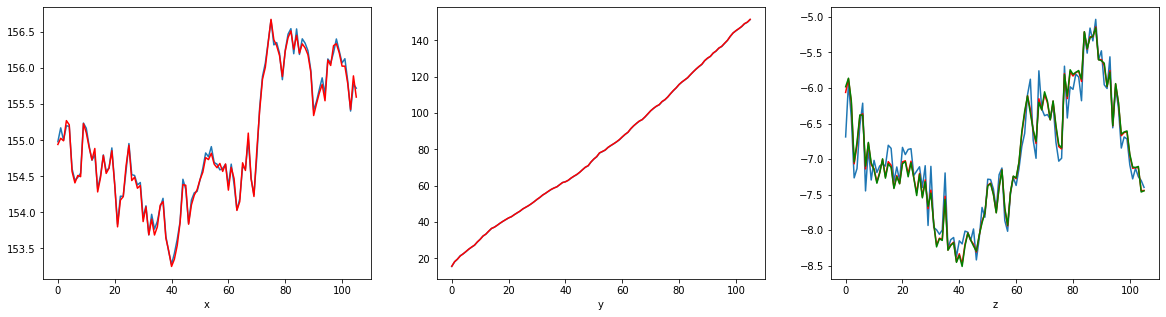

PARTICLE ID: 252  z_mult: 1.774, improvement: 0.52
PARTICLE ID: 253  z_mult: 2.011, improvement: 0.69
PARTICLE ID: 254  z_mult: 1.577, improvement: 0.45
PARTICLE ID: 255  z_mult: 1.593, improvement: 0.40
PARTICLE ID: 256  z_mult: 1.197, improvement: 0.54
PARTICLE ID: 257  z_mult: 2.587, improvement: 0.66
PARTICLE ID: 258  z_mult: 1.411, improvement: 0.53
PARTICLE ID: 259  z_mult: 1.853, improvement: 0.47
PARTICLE ID: 260  z_mult: 1.956, improvement: 0.84
PARTICLE ID: 261  z_mult: 2.031, improvement: 0.29
PARTICLE ID: 262  z_mult: 1.780, improvement: 0.45
PARTICLE ID: 263  z_mult: 2.124, improvement: 0.55
PARTICLE ID: 264  z_mult: 1.146, improvement: 0.27
PARTICLE ID: 265  z_mult: 1.715, improvement: 0.47
PARTICLE ID: 266  z_mult: 1.974, improvement: 0.56
PARTICLE ID: 267  z_mult: 1.765, improvement: 0.46
PARTICLE ID: 268  z_mult: 2.125, improvement: 0.54
PARTICLE ID: 269  z_mult: 0.465, improvement: 0.87
PARTICLE ID: 270  z_mult: 1.513, improvement: 0.41
PARTICLE ID: 271  z_mult: 2.325

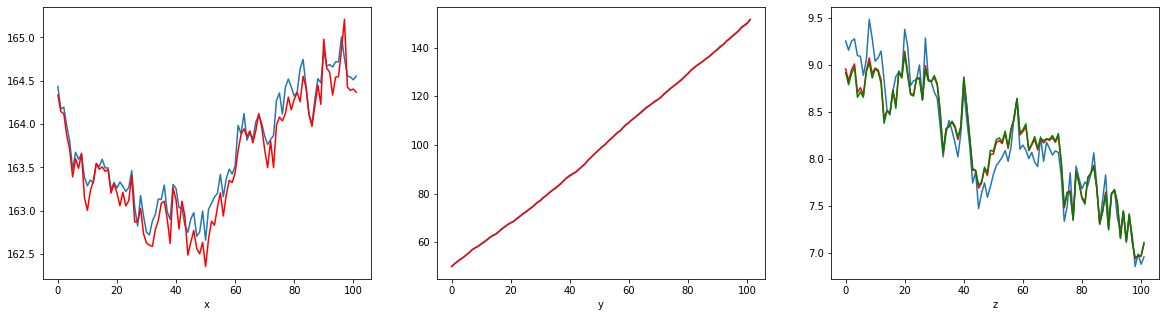

PARTICLE ID: 278  z_mult: 0.703, improvement: 0.49
PARTICLE ID: 279  z_mult: 1.820, improvement: 0.49
PARTICLE ID: 280  z_mult: 2.754, improvement: 0.44
PARTICLE ID: 281  z_mult: 1.884, improvement: 0.62
PARTICLE ID: 282  z_mult: 1.469, improvement: 0.68
PARTICLE ID: 283  z_mult: 1.603, improvement: 0.46
PARTICLE ID: 284  z_mult: 1.513, improvement: 0.72


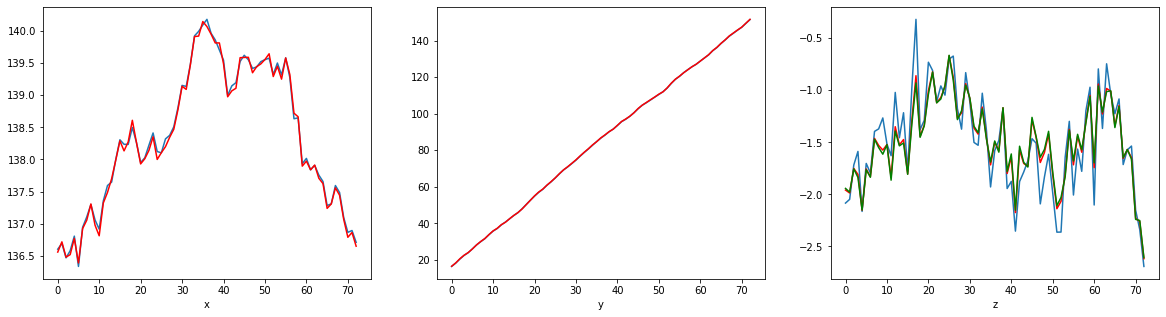

PARTICLE ID: 285  z_mult: 1.639, improvement: 0.45
PARTICLE ID: 286  z_mult: 1.487, improvement: 0.37


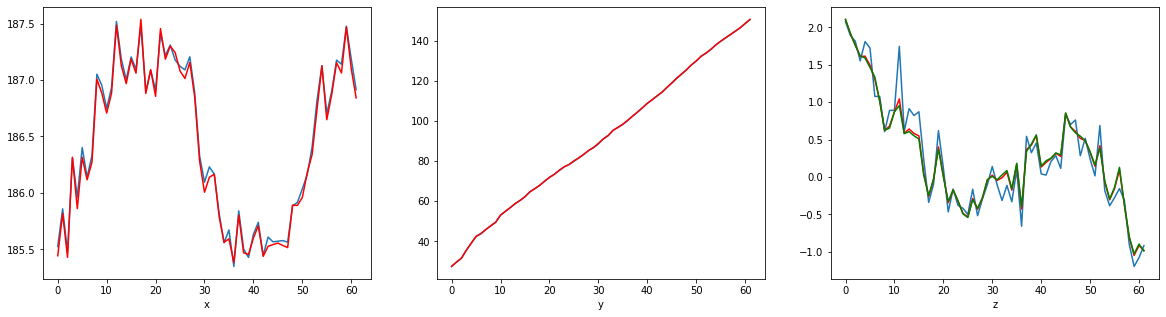

PARTICLE ID: 287  z_mult: 2.131, improvement: 0.68
PARTICLE ID: 288  z_mult: 2.281, improvement: 0.64
PARTICLE ID: 289  z_mult: 1.829, improvement: 0.50
PARTICLE ID: 290  z_mult: 2.757, improvement: 0.66
PARTICLE ID: 291  z_mult: 2.615, improvement: 0.63
PARTICLE ID: 292  z_mult: 1.641, improvement: 0.47
PARTICLE ID: 293  z_mult: 1.051, improvement: 0.94
PARTICLE ID: 294  z_mult: 2.143, improvement: 0.39
PARTICLE ID: 295  z_mult: 1.906, improvement: 0.54
PARTICLE ID: 296  z_mult: 1.837, improvement: 0.48
PARTICLE ID: 297  z_mult: 2.007, improvement: 0.39
PARTICLE ID: 298  z_mult: 1.748, improvement: 0.48
PARTICLE ID: 299  z_mult: 1.516, improvement: 0.41
PARTICLE ID: 300  PARTICLE ID: 301  z_mult: 0.973, improvement: 0.12
PARTICLE ID: 302  z_mult: 0.836, improvement: 0.71
PARTICLE ID: 303  z_mult: 2.022, improvement: 0.40
PARTICLE ID: 304  z_mult: 1.787, improvement: 0.51
PARTICLE ID: 305  z_mult: 1.802, improvement: 0.73
PARTICLE ID: 306  z_mult: 0.986, improvement: 0.08
PARTICLE ID: 

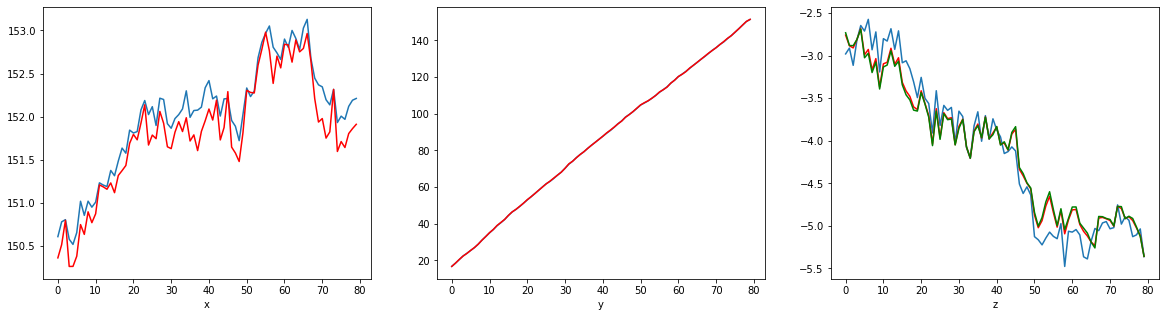

PARTICLE ID: 310  z_mult: 2.765, improvement: 0.94
PARTICLE ID: 311  z_mult: 0.788, improvement: 0.58
PARTICLE ID: 312  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


z_mult: 1.606, improvement: 0.48
PARTICLE ID: 313  z_mult: 1.658, improvement: 0.48
PARTICLE ID: 314  z_mult: 1.217, improvement: 0.50


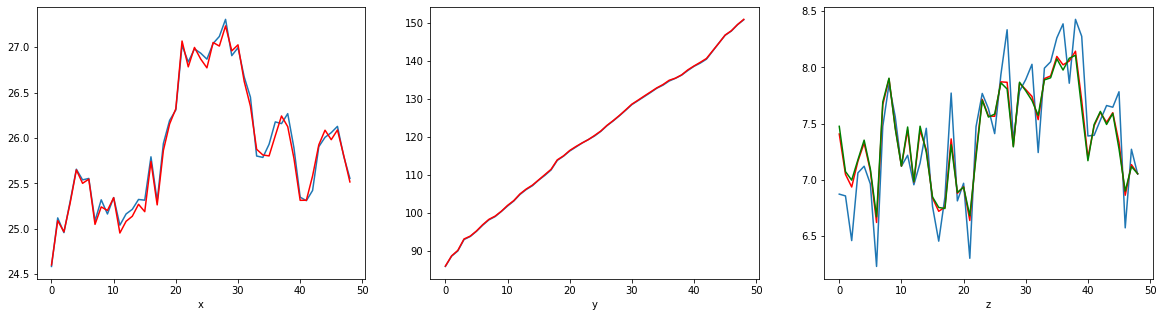

PARTICLE ID: 315  z_mult: 1.513, improvement: 0.48
PARTICLE ID: 316  z_mult: 1.147, improvement: 0.63


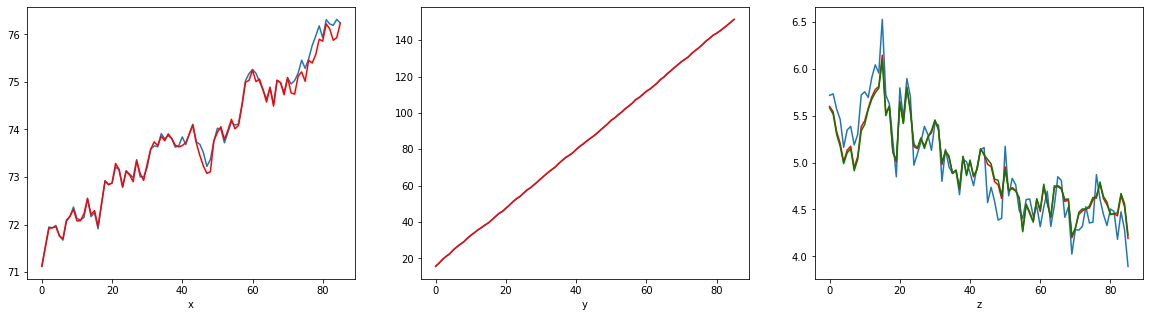

PARTICLE ID: 317  z_mult: 1.432, improvement: 0.66
PARTICLE ID: 318  z_mult: 1.345, improvement: 0.68


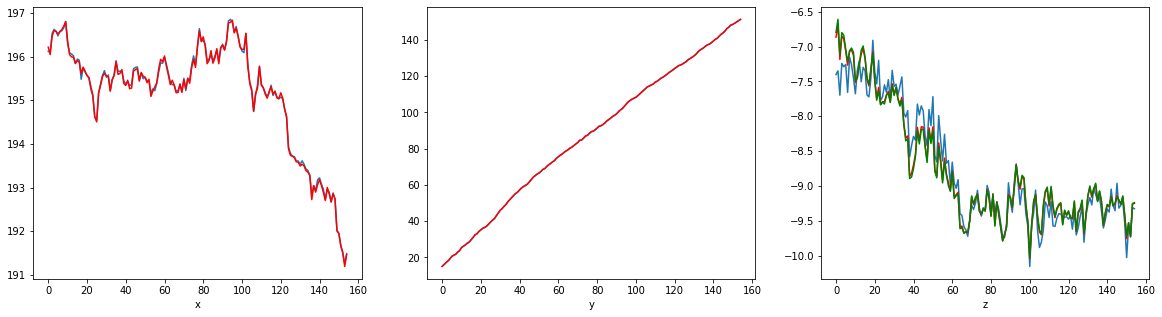

PARTICLE ID: 319  z_mult: 2.928, improvement: 0.70
PARTICLE ID: 320  z_mult: 0.900, improvement: 0.26
PARTICLE ID: 321  z_mult: 1.799, improvement: 0.63
PARTICLE ID: 322  z_mult: 2.921, improvement: 0.50
PARTICLE ID: 323  z_mult: 1.214, improvement: 0.59
PARTICLE ID: 324  z_mult: 2.271, improvement: 0.79
PARTICLE ID: 325  z_mult: 1.795, improvement: 0.52
PARTICLE ID: 326  z_mult: 1.544, improvement: 0.45
PARTICLE ID: 327  z_mult: 2.884, improvement: 0.72
PARTICLE ID: 328  z_mult: 2.935, improvement: 0.73
PARTICLE ID: 329  z_mult: 1.290, improvement: 0.28
PARTICLE ID: 330  z_mult: -0.548, improvement: 1.27
PARTICLE ID: 331  z_mult: 1.997, improvement: 0.62
PARTICLE ID: 332  z_mult: 1.720, improvement: 0.49
PARTICLE ID: 333  z_mult: 1.240, improvement: 0.24
PARTICLE ID: 334  z_mult: 1.955, improvement: 0.49
PARTICLE ID: 335  z_mult: 2.194, improvement: 0.57
PARTICLE ID: 336  z_mult: 1.110, improvement: 0.23
PARTICLE ID: 337  z_mult: 2.099, improvement: 0.58
PARTICLE ID: 338  z_mult: 1.70

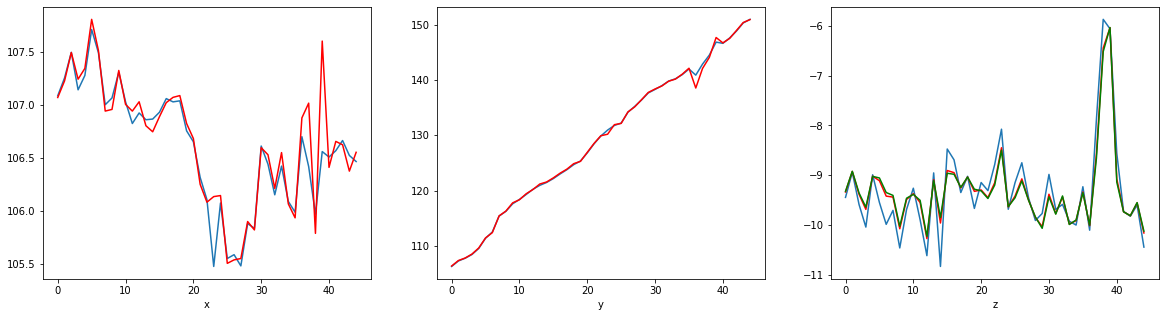

PARTICLE ID: 341  z_mult: 0.352, improvement: 0.51


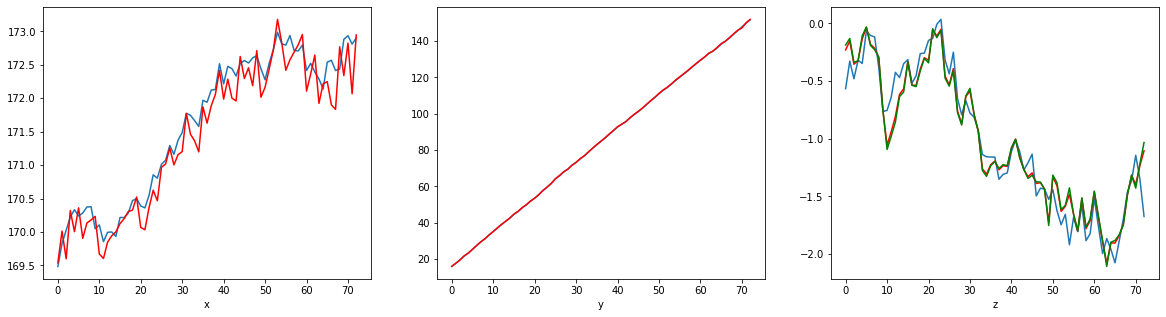

PARTICLE ID: 342  z_mult: 1.418, improvement: 0.58
PARTICLE ID: 343  z_mult: 1.114, improvement: 0.87
PARTICLE ID: 344  z_mult: 1.171, improvement: 0.72
PARTICLE ID: 345  z_mult: -0.025, improvement: 11.21


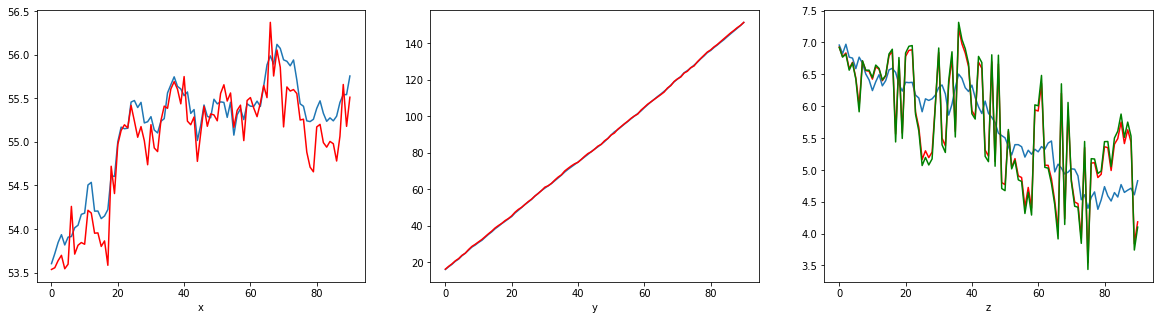

PARTICLE ID: 346  z_mult: 2.380, improvement: 0.58
PARTICLE ID: 347  z_mult: 1.979, improvement: 0.51
PARTICLE ID: 348  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


z_mult: 1.004, improvement: 0.04
PARTICLE ID: 349  z_mult: 1.558, improvement: 0.53
PARTICLE ID: 350  PARTICLE ID: 351  z_mult: 1.782, improvement: 0.54
PARTICLE ID: 352  z_mult: 1.889, improvement: 0.50
PARTICLE ID: 353  z_mult: 2.179, improvement: 0.63
PARTICLE ID: 354  z_mult: 1.350, improvement: 0.73
PARTICLE ID: 355  z_mult: 1.585, improvement: 0.63


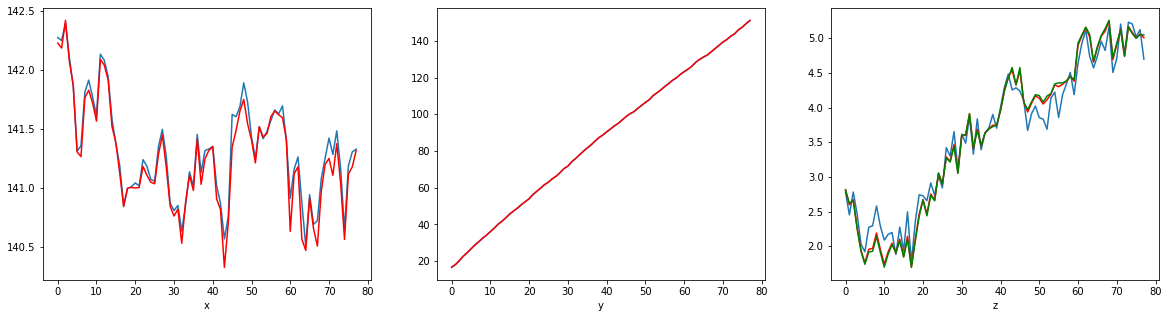

PARTICLE ID: 356  z_mult: 1.935, improvement: 0.55
PARTICLE ID: 357  z_mult: 2.151, improvement: 0.59
PARTICLE ID: 358  z_mult: 0.563, improvement: 0.89


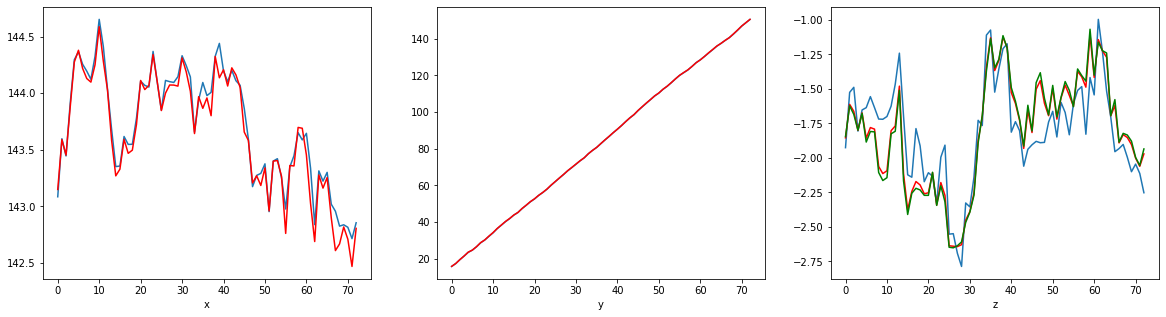

PARTICLE ID: 359  z_mult: 1.389, improvement: 0.40
PARTICLE ID: 360  z_mult: 1.983, improvement: 0.57
PARTICLE ID: 361  z_mult: 2.042, improvement: 0.57
PARTICLE ID: 362  z_mult: 1.916, improvement: 0.56
PARTICLE ID: 363  z_mult: 2.246, improvement: 0.30
PARTICLE ID: 364  z_mult: 2.513, improvement: 0.62
PARTICLE ID: 365  z_mult: 2.491, improvement: 0.63
PARTICLE ID: 366  z_mult: 2.660, improvement: 0.39
PARTICLE ID: 367  z_mult: 1.578, improvement: 0.55
PARTICLE ID: 368  z_mult: 1.369, improvement: 0.69
PARTICLE ID: 369  z_mult: 6.531, improvement: 0.98
PARTICLE ID: 370  z_mult: 2.106, improvement: 0.59
PARTICLE ID: 371  z_mult: 1.895, improvement: 0.59
PARTICLE ID: 372  z_mult: 1.800, improvement: 0.46
PARTICLE ID: 373  z_mult: 1.327, improvement: 0.47
PARTICLE ID: 374  z_mult: 1.497, improvement: 0.39
PARTICLE ID: 375  z_mult: 1.652, improvement: 0.48
PARTICLE ID: 376  z_mult: 1.522, improvement: 0.47
PARTICLE ID: 377  z_mult: 1.044, improvement: 0.89
PARTICLE ID: 378  z_mult: 1.557

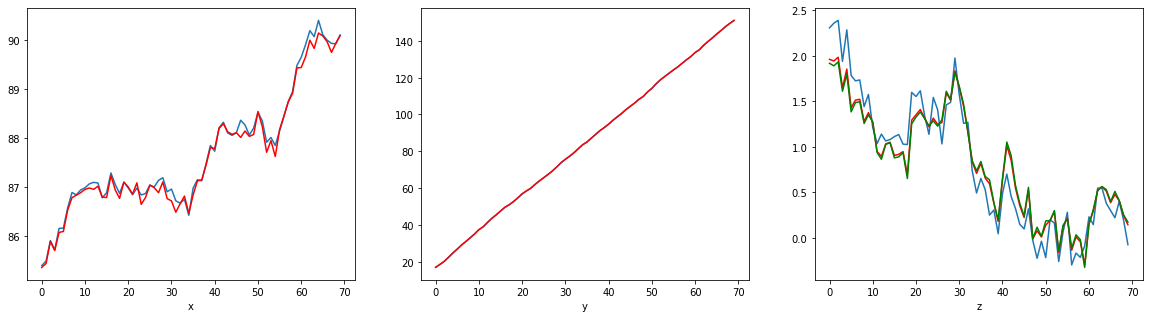

PARTICLE ID: 387  z_mult: 2.150, improvement: 1.10
PARTICLE ID: 388  z_mult: 1.950, improvement: 0.58
PARTICLE ID: 389  z_mult: 1.487, improvement: 0.37
PARTICLE ID: 390  z_mult: 1.086, improvement: 0.50
PARTICLE ID: 391  z_mult: 2.824, improvement: 4.64
PARTICLE ID: 392  z_mult: 2.038, improvement: 0.54
PARTICLE ID: 393  z_mult: 1.999, improvement: 0.53
PARTICLE ID: 394  z_mult: 1.411, improvement: 0.47
PARTICLE ID: 395  z_mult: 1.971, improvement: 0.45
PARTICLE ID: 396  z_mult: 1.840, improvement: 0.58
PARTICLE ID: 397  z_mult: 1.106, improvement: 0.21


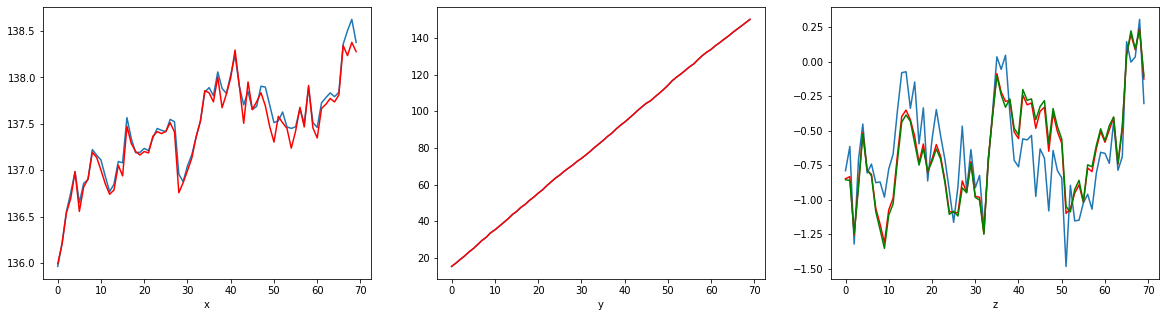

PARTICLE ID: 398  z_mult: 2.184, improvement: 0.62
PARTICLE ID: 399  z_mult: 1.910, improvement: 0.53


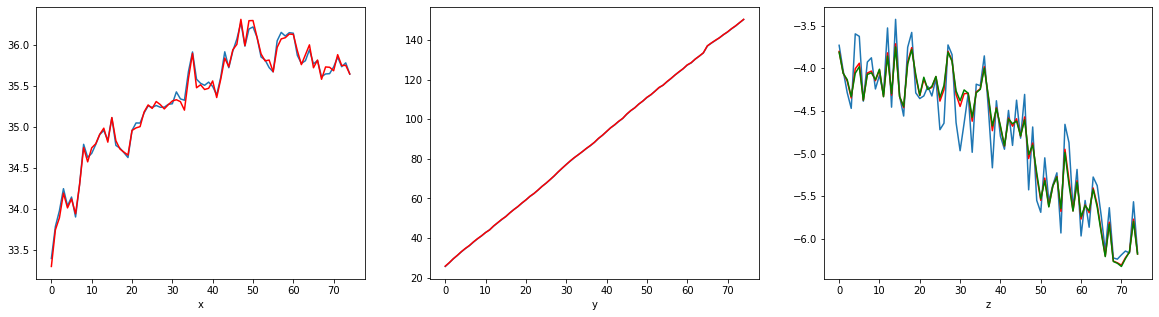

PARTICLE ID: 400  PARTICLE ID: 401  z_mult: 1.655, improvement: 0.43
PARTICLE ID: 402  z_mult: -0.022, improvement: 1.23
PARTICLE ID: 403  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


z_mult: 1.955, improvement: 0.50
PARTICLE ID: 404  z_mult: 1.633, improvement: 0.47
PARTICLE ID: 405  z_mult: 2.320, improvement: 0.60
PARTICLE ID: 406  z_mult: -2.130, improvement: 1.13
PARTICLE ID: 407  z_mult: 1.427, improvement: 0.19
PARTICLE ID: 408  z_mult: 1.886, improvement: 0.49
PARTICLE ID: 409  z_mult: 1.367, improvement: 0.44
PARTICLE ID: 410  z_mult: 2.086, improvement: 0.56
PARTICLE ID: 411  z_mult: 1.698, improvement: 0.44
PARTICLE ID: 412  z_mult: 1.353, improvement: 0.32
PARTICLE ID: 413  z_mult: 2.695, improvement: 1.41
PARTICLE ID: 414  z_mult: 2.021, improvement: 0.51
PARTICLE ID: 415  z_mult: 1.667, improvement: 0.56
PARTICLE ID: 416  z_mult: 1.798, improvement: 0.47
PARTICLE ID: 417  z_mult: 0.249, improvement: 1.06
PARTICLE ID: 418  z_mult: 1.043, improvement: 0.69
PARTICLE ID: 419  z_mult: 2.311, improvement: 0.60
PARTICLE ID: 420  z_mult: 1.984, improvement: 0.60


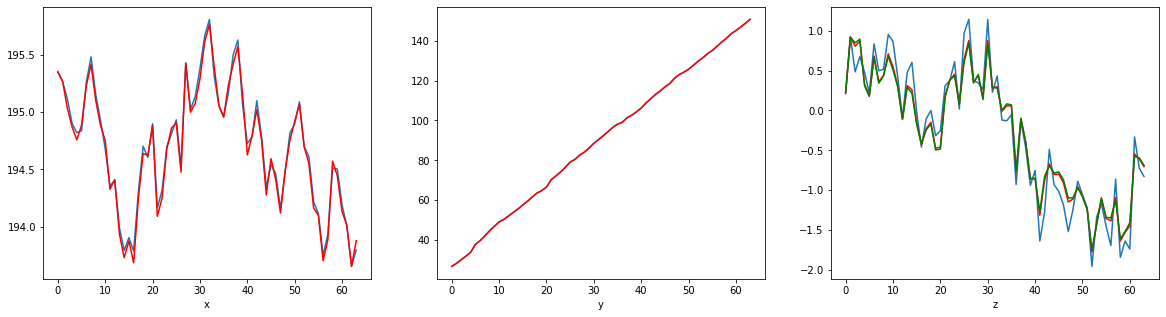

PARTICLE ID: 421  z_mult: 1.759, improvement: 0.48
PARTICLE ID: 422  z_mult: 2.005, improvement: 0.40
PARTICLE ID: 423  z_mult: 2.831, improvement: 0.59
PARTICLE ID: 424  z_mult: 1.317, improvement: 0.53
PARTICLE ID: 425  z_mult: 1.816, improvement: 3.13
PARTICLE ID: 426  z_mult: 0.984, improvement: 0.41
PARTICLE ID: 427  z_mult: 1.954, improvement: 0.49
PARTICLE ID: 428  z_mult: 1.635, improvement: 0.42
PARTICLE ID: 429  z_mult: 1.726, improvement: 0.48
PARTICLE ID: 430  z_mult: 1.837, improvement: 0.58


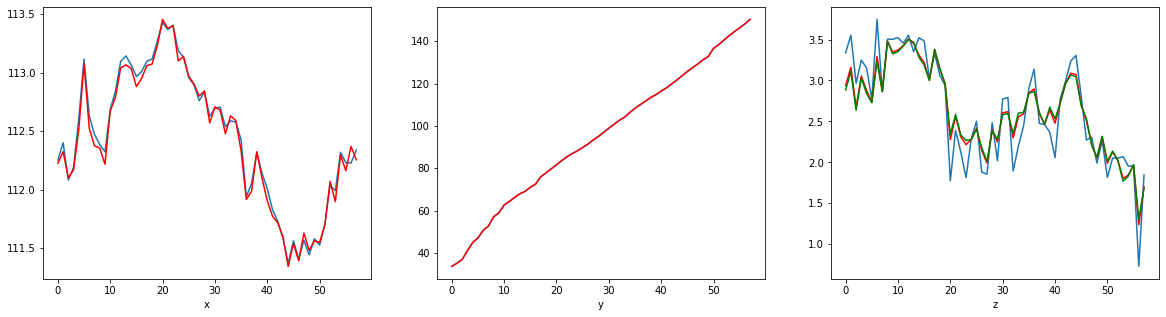

PARTICLE ID: 431  z_mult: 0.165, improvement: 1.04


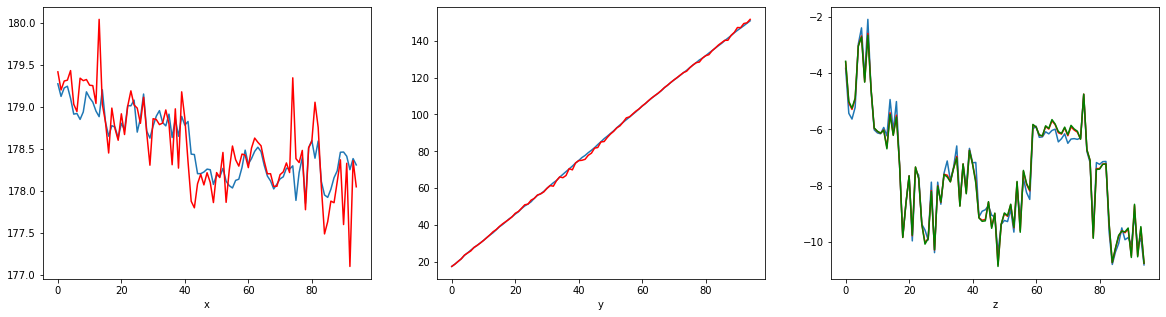

PARTICLE ID: 432  z_mult: 1.318, improvement: 0.37
PARTICLE ID: 433  z_mult: 0.876, improvement: 0.22
PARTICLE ID: 434  z_mult: 1.933, improvement: 0.59
PARTICLE ID: 435  z_mult: 1.824, improvement: 0.52
PARTICLE ID: 436  z_mult: 1.831, improvement: 0.50
PARTICLE ID: 437  z_mult: 1.855, improvement: 0.62
PARTICLE ID: 438  z_mult: 0.150, improvement: 1.27


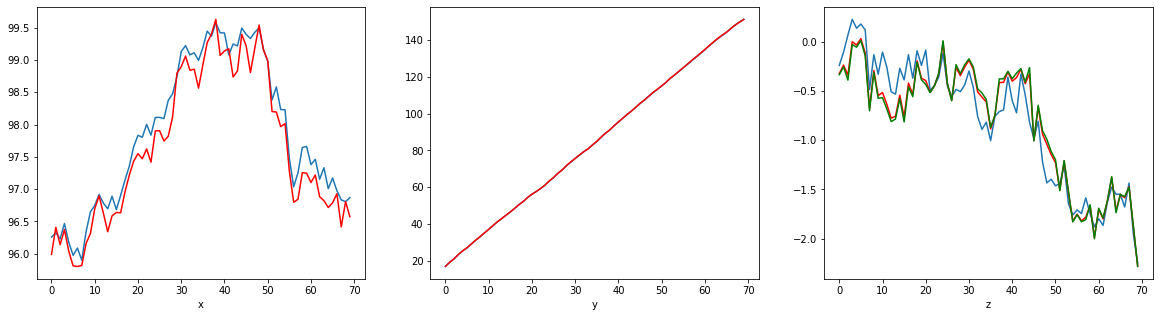

PARTICLE ID: 439  z_mult: 1.375, improvement: 0.35
PARTICLE ID: 440  z_mult: 1.832, improvement: 0.49
PARTICLE ID: 441  z_mult: 2.002, improvement: 0.60
PARTICLE ID: 442  z_mult: 2.923, improvement: 0.76
PARTICLE ID: 443  z_mult: 2.070, improvement: 0.58
PARTICLE ID: 444  z_mult: 2.437, improvement: 0.74
PARTICLE ID: 445  z_mult: 1.645, improvement: 0.43
PARTICLE ID: 446  z_mult: 1.474, improvement: 0.51
PARTICLE ID: 447  z_mult: 1.059, improvement: 0.95
PARTICLE ID: 448  z_mult: 3.139, improvement: 0.44
PARTICLE ID: 449  z_mult: 2.434, improvement: 0.59
PARTICLE ID: 450  PARTICLE ID: 451  z_mult: 1.283, improvement: 0.62


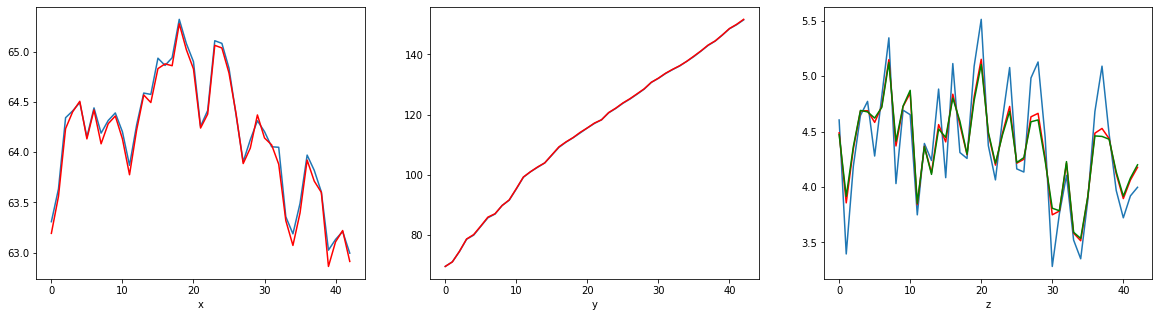

PARTICLE ID: 452  z_mult: 1.809, improvement: 0.57
PARTICLE ID: 453  z_mult: 2.370, improvement: 1.00
PARTICLE ID: 454  z_mult: 1.537, improvement: 0.57


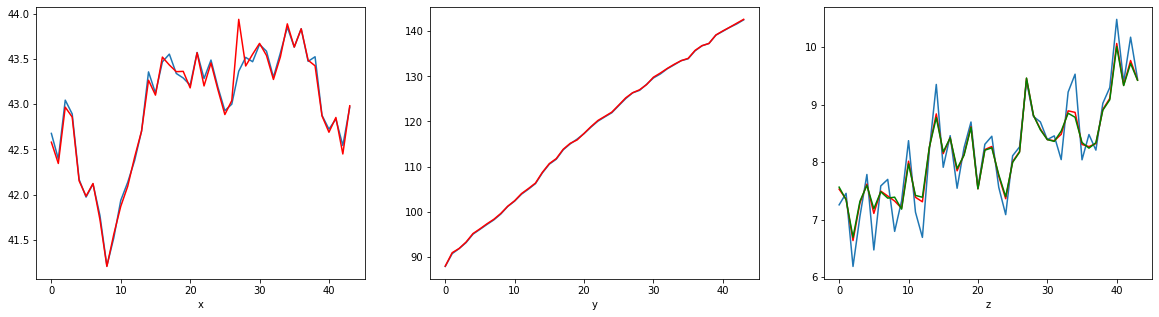

PARTICLE ID: 455  z_mult: 1.947, improvement: 0.51
PARTICLE ID: 456  z_mult: 1.057, improvement: 0.15
PARTICLE ID: 457  z_mult: 1.075, improvement: 0.21
PARTICLE ID: 458  z_mult: 1.781, improvement: 0.62
PARTICLE ID: 459  z_mult: 1.794, improvement: 0.52
PARTICLE ID: 460  z_mult: 1.660, improvement: 0.61
PARTICLE ID: 461  z_mult: 2.015, improvement: 0.52
PARTICLE ID: 462  z_mult: 2.248, improvement: 0.64
PARTICLE ID: 463  z_mult: 0.728, improvement: 0.68


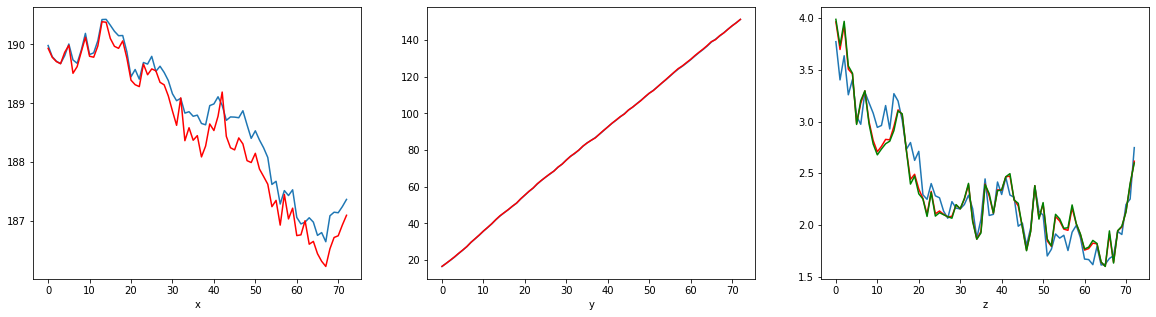

PARTICLE ID: 464  z_mult: 1.099, improvement: 0.27
PARTICLE ID: 465  z_mult: 1.096, improvement: 0.23
PARTICLE ID: 466  z_mult: 1.332, improvement: 0.32
PARTICLE ID: 467  z_mult: 1.214, improvement: 0.57
PARTICLE ID: 468  z_mult: 2.505, improvement: 0.62
PARTICLE ID: 469  z_mult: 2.179, improvement: 0.35
PARTICLE ID: 470  z_mult: 1.297, improvement: 0.27
PARTICLE ID: 471  z_mult: 1.980, improvement: 0.54
PARTICLE ID: 472  z_mult: 0.545, improvement: 0.99
PARTICLE ID: 473  z_mult: 2.041, improvement: 0.45
PARTICLE ID: 474  z_mult: 1.627, improvement: 0.42
PARTICLE ID: 475  z_mult: 1.699, improvement: 0.47


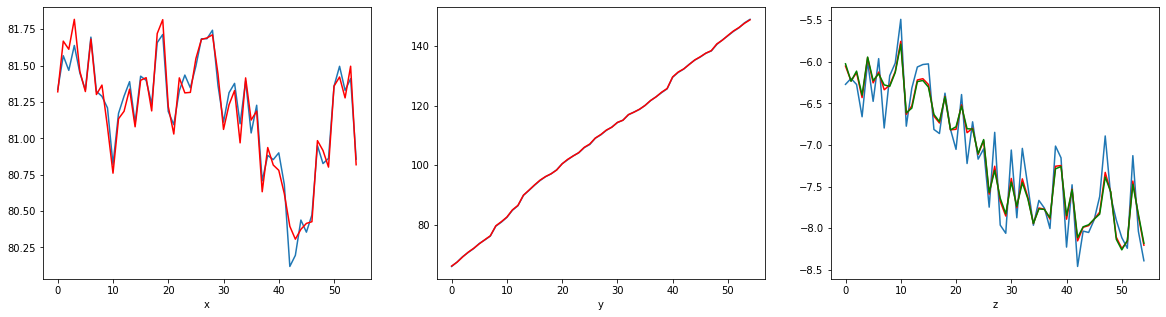

PARTICLE ID: 476  z_mult: 1.703, improvement: 0.48
PARTICLE ID: 477  z_mult: 1.726, improvement: 1.00
PARTICLE ID: 478  z_mult: 2.193, improvement: 0.65
PARTICLE ID: 479  z_mult: 1.514, improvement: 0.50
PARTICLE ID: 480  z_mult: 1.703, improvement: 0.49
PARTICLE ID: 481  z_mult: 1.846, improvement: 0.55
PARTICLE ID: 482  z_mult: 2.289, improvement: 0.64
PARTICLE ID: 483  z_mult: 2.873, improvement: 0.60
PARTICLE ID: 484  z_mult: 1.517, improvement: 0.41
PARTICLE ID: 485  z_mult: 2.564, improvement: 0.54
PARTICLE ID: 486  z_mult: 1.813, improvement: 0.66
PARTICLE ID: 487  z_mult: 2.216, improvement: 0.67
PARTICLE ID: 488  z_mult: 1.422, improvement: 0.48
PARTICLE ID: 489  z_mult: -0.527, improvement: 1.47
PARTICLE ID: 490  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


z_mult: 1.382, improvement: 0.84
PARTICLE ID: 491  z_mult: 1.494, improvement: 0.51
PARTICLE ID: 492  z_mult: 2.910, improvement: 0.52
PARTICLE ID: 493  z_mult: 1.512, improvement: 0.51
PARTICLE ID: 494  z_mult: 1.194, improvement: 0.35
PARTICLE ID: 495  z_mult: 2.050, improvement: 0.57
PARTICLE ID: 496  z_mult: 1.398, improvement: 0.40
PARTICLE ID: 497  z_mult: 2.376, improvement: 0.63
PARTICLE ID: 498  z_mult: 0.757, improvement: 0.94
PARTICLE ID: 499  z_mult: 1.737, improvement: 0.59
PARTICLE ID: 500  PARTICLE ID: 501  z_mult: 2.070, improvement: 0.56
PARTICLE ID: 502  z_mult: 0.435, improvement: 1.11
PARTICLE ID: 503  z_mult: 2.860, improvement: 0.83
PARTICLE ID: 504  z_mult: 1.660, improvement: 0.57
PARTICLE ID: 505  z_mult: 1.866, improvement: 0.49
PARTICLE ID: 506  z_mult: 2.120, improvement: 0.55
PARTICLE ID: 507  z_mult: 1.728, improvement: 0.59
PARTICLE ID: 508  z_mult: 2.027, improvement: 0.52
PARTICLE ID: 509  z_mult: 0.797, improvement: 0.81
PARTICLE ID: 510  z_mult: 1.334

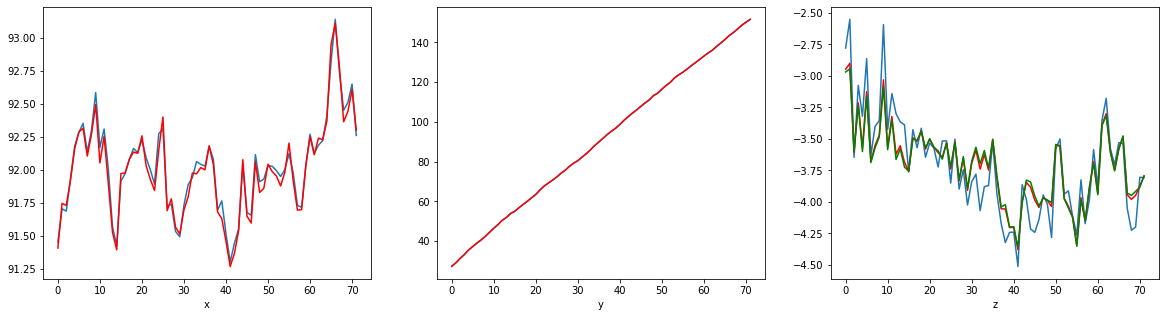

PARTICLE ID: 512  z_mult: 3.227, improvement: 0.82
PARTICLE ID: 513  z_mult: 2.136, improvement: 3.08
PARTICLE ID: 514  z_mult: 1.544, improvement: 0.91


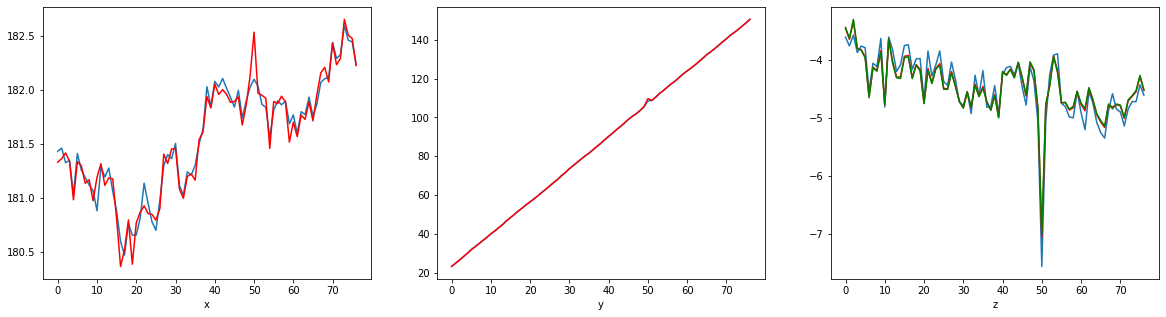

PARTICLE ID: 515  z_mult: 1.219, improvement: 0.49
optimal mult.factor: 1.6705527662770565


In [76]:
from scipy.optimize import minimize

original_model = models[-1]
def compare_lode_matlab(val_stack):
    z_mults = []
    traces_matlab = []
    traces_lode = []
    for particle_id in range(len(val_stack)):
        print("PARTICLE ID:", particle_id, end="  ")

        training_images = np.stack((np.real(particles_timeseries[particle_id])[:,:,:,0], np.imag(particles_timeseries[particle_id][:,:,:,0])), axis=-1)
        validation_set = particles_timeseries[particle_id][:,:,:,:]

        training_set = create_training_set([particles_timeseries[particle_id]])

        generator = dt.models.lodestar.LodeSTARGenerator(
            training_set,
            num_outputs=num_outputs, 
            transformation_function=(group, equivariance), 
            batch_size=8, 
            min_data_size=100, 
            max_data_size=101,
        )

        model = original_model
        if particle_id%50==0:
            continue
            with generator:
                h = model.fit(generator, epochs=15, steps_per_epoch=50, verbose=0)


        timeseries = np.stack( (np.real(val_stack[particle_id][:,:,:,0]), np.imag(val_stack[particle_id][:,:,:,0])), axis=-1)
        corrections = predict_on_stack(model, timeseries)
        x_lode, y_lode, z_lode = corrections[:,0], corrections[:,1], corrections[:,2]
        x_matlab, y_matlab, z_matlab = particles_positions[particle_id][:,0], particles_positions[particle_id][:,1], particles_positions[particle_id][:,2]

        z_lode = z_lode/-10
        z_lode = z_lode - np.mean(z_lode)
        x_new, y_new, z_new = x_matlab+(32+x_lode)*0.114, y_matlab+(32+y_lode)*0.114, z_lode+z_matlab
        z_oil_maybe = z_matlab+z_lode*1.5/1.33
        z_shoudlnt = z_matlab+z_lode*1.6



        #plt.imshow(np.abs(timeseries[0,:,:,0]+1j*timeseries[0,:,:,1]))
        #plt.show()


        #print(f"sigma_x_matlab: {calc_sigma(x_matlab):.3f}")
        #print(f"sigma_x_new: {calc_sigma(x_new):.3f}\n")

        #print(f"sigma_y_matlab: {calc_sigma(y_matlab):.3f}")
        #print(f"sigma_y_new: {calc_sigma(y_new):.3f}\n")

        #print(f"sigma_z_matlab: {calc_sigma(z_matlab):.3f}")
        #print(f"sigma_z_new: {calc_sigma(z_new):.3f}")
        #print(f"sigma_z_oil: {calc_sigma(z_oil_maybe):.3f}")
        #print(f"sigma_z_multfact: {calc_sigma(z_shoudlnt):.3f}")

        def sigma_z(x):
            arr = z_matlab + z_lode*x
            return calc_sigma(arr)

        z_mult = minimize(sigma_z, [1], method="Powell").x
        print(f"z_mult: {z_mult:.3f}, improvement: {calc_sigma(z_new)/calc_sigma(z_matlab):.2f}")

        if len(x_matlab) > 40:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
            ax1.plot(list(range(len(x_matlab))), x_matlab)
            ax1.set_xlabel("x")
            ax1.plot(list(range(len(x_lode))), x_new, 'r')

            ax2.plot(list(range(len(y_matlab))), y_matlab)
            ax2.plot(list(range(len(y_lode))), y_new, 'r')
            ax2.set_xlabel("y")

            ax3.plot(list(range(len(z_matlab))), z_matlab)
            ax3.plot(list(range(len(z_lode))), z_new, 'r')
            ax3.plot(list(range(len(z_oil_maybe))), z_oil_maybe, 'g')
            ax3.set_xlabel("z")
            plt.show()

        z_mults.append(z_mult)
        traces_matlab.append(np.array([x_matlab, y_matlab, z_matlab]))
        traces_lode.append(np.array([x_lode*0.114*0, y_lode*0.114*0, z_lode]))

    return traces_matlab, traces_lode, z_mults

traces_matlab, traces_lode, z_mults = compare_lode_matlab(particles_timeseries)
print(f"optimal mult.factor: {np.mean(z_mults)}")

In [77]:
sigmas_matlab = np.array(
    [calc_sigma(trace[2,:]) for trace in traces_matlab]
    )

sigmas_new = np.array(
    [calc_sigma(trace[2,:]) for trace in [sum(x) for x in zip(traces_matlab, traces_lode)]]
    )

def id_new_better_than_matlab(new_sigmas, matlab_sigmas):
    out = []
    for i in range(new_sigmas.shape[0]):
        #print(i, f"   {np.linalg.norm(new_sigmas[i,:])/np.linalg.norm(matlab_sigmas[i,:]):.2f}", f"   {np.linalg.norm(new_sigmas[i,2])/np.linalg.norm(matlab_sigmas[i,2]):.2f}")
        if np.linalg.norm(new_sigmas[i]) < np.linalg.norm(matlab_sigmas[i]):
            out.append(i)
    return out


#OPTIMAL MULT.FAKTOR: 1.600333833

bin = np.linspace(0,0.5,10)
ids = id_new_better_than_matlab(sigmas_new, sigmas_matlab)
print(len(ids), len(particles_timeseries))
print(f"korrigerad sigma_z: {np.mean(sigmas_new[ids])}, matlabs sigma_z: {np.mean(sigmas_matlab[ids])}")

468 516
korrigerad sigma_z: 0.23400106756375397, matlabs sigma_z: 0.4317283762319363


In [78]:
def get_msd(x, max_dt=4):

    output = []
    for delt in range(max_dt):
        delta_x = x[1 + delt :] - x[: -(1 + delt)]
        
        th = 100 * np.sqrt(delt + 1)
        if np.any(delta_x > th):
            print(np.sum(delta_x > th))

        delta_x[delta_x > th] = 0
        squared_displacement = np.square(delta_x)#.sum(axis=-1)
        length = len(squared_displacement)
        output.append(
            (
                np.mean(squared_displacement),
                np.std(squared_displacement),
                length,
            )
        )

    return np.array(output)

def fit_to_line(msd):
    return np.polyfit(range(1, msd.shape[0]+1), msd[:, 0], 1)

Matlabs trace (i z-led) plus 0.00 gånger lodestars prediktion


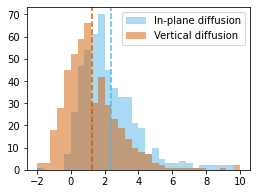

Matlabs trace (i z-led) plus 1.00 gånger lodestars prediktion


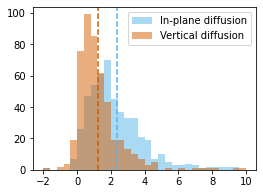

Matlabs trace (i z-led) plus 1.13 gånger lodestars prediktion


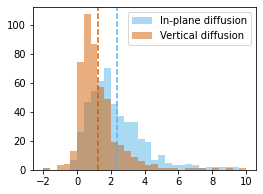

Matlabs trace (i z-led) plus 1.60 gånger lodestars prediktion


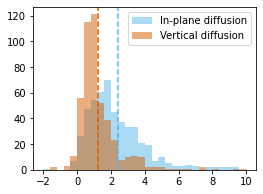

In [109]:
import seaborn

def plot_diffusion(traces, shortest_trace=5):
    delta_time = 1/42
    msds = []
    msds_z = []

    _traces = [trace for trace in traces if trace.shape[1]>shortest_trace]

    for pos in _traces:
        msd = get_msd(pos[0,:], 10) 
        a, b = fit_to_line(msd[:4])
        msds.append(a)

        msd_z = get_msd(pos[2,:], 10)
        a, b = fit_to_line(msd_z[:4])
        msds_z.append(a)

    x_diffuse, z_diffuse = np.array(msds) / delta_time / 2, np.array(msds_z) / delta_time / 2
    x_diffuse = [elem for elem in x_diffuse if elem<10*np.median(x_diffuse)] # är detta okej statistiskt?? kanske inte
    z_diffuse = [elem for elem in z_diffuse if elem<10*np.median(z_diffuse)]

    plt.figure(figsize=(4, 3))

    plt.axvline(np.mean(x_diffuse), c=seaborn.color_palette("colorblind")[9], linestyle="--")
    plt.axvline(np.mean(z_diffuse), c=seaborn.color_palette("colorblind")[3], linestyle="--")

    plt.hist(x_diffuse, 30, alpha=0.5, range=(-2,10), facecolor=seaborn.color_palette("colorblind")[9], label="In-plane diffusion")
    plt.hist(z_diffuse, 30, alpha=0.5, range=(-2,10), facecolor=seaborn.color_palette("colorblind")[3], label="Vertical diffusion")
    #plt.yticks([])
    plt.legend()
    plt.show()

#plot_diffusion(traces_matlab)
#plot_diffusion([sum(x) for x in zip(traces_matlab, traces_lode)])
x=[0,1,1.5/1.33,1.6]
for mul in x:
    print(f"Matlabs trace (i z-led) plus {mul:.2f} gånger lodestars prediktion")
    plot_diffusion([x[0]+x[1]*mul for x in zip(traces_matlab, traces_lode)])